<a href="https://colab.research.google.com/github/fabriziobasso/Colab_backup/blob/main/rain_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **S4E10 - Rain Forecast**

<div class="container">
        <h1 class="mb-2">Problem Statement</h1>
        <p class="mb-2">
            Analyze weather data over a 5-day period to identify patterns and correlations between various meteorological factors such as pressure, temperature, humidity, and rainfall. This can help in understanding how these variables influence daily weather conditions.
        </p>
        <h1 class="mb-2">Dataset Description</h1>
        <p class="mb-2">The dataset captures weather data over five days with the following features:</p>
        <ul class="mb-2">
            <li class="mb-2"><strong>day:</strong> Sequential day number.</li>
            <li class="mb-2"><strong>pressure (hPa):</strong> Atmospheric pressure measured in hectopascals.</li>
            <li class="mb-2"><strong>maxtemp (°C):</strong> Maximum temperature recorded on the day.</li>
            <li class="mb-2"><strong>temperature (°C):</strong> Average temperature of the day.</li>
            <li class="mb-2"><strong>mintemp (°C):</strong> Minimum temperature recorded on the day.</li>
            <li class="mb-2"><strong>dewpoint (°C):</strong> Temperature at which air becomes saturated with moisture.</li>
            <li class="mb-2"><strong>humidity (%):</strong> Relative humidity percentage.</li>
            <li class="mb-2"><strong>cloud (%):</strong> Cloud cover percentage.</li>
            <li class="mb-2"><strong>rainfall:</strong> Indicates if rainfall occurred ("yes"/"no").</li>
            <li class="mb-2"><strong>sunshine (hours):</strong> Total sunshine hours.</li>
            <li class="mb-2"><strong>winddirection (°):</strong> Direction of the wind in degrees.</li>
            <li class="mb-2"><strong>windspeed (km/h):</strong> Speed of the wind.</li>
        </ul>
        <p class="mb-2">
            This dataset is ideal for basic weather pattern analysis and visualization.
        </p>
    </div>

In [1]:
%%capture
#!pip install -qq pytorch_tabnet
!pip install optuna
!pip install catboost
#!pip install optuna-integration-pytorch-tabnet

#from pytorch_tabnet.tab_model import TabNetRegressor

!pip install --upgrade category-encoders
!pip install optuna-integration
!pip install colorama
#!pip install pyfiglet
!pip install keras-tuner --upgrade
!pip install keras-nlp
!pip install BorutaShap
!pip install --upgrade scikit-learn
!pip install scikit-lego
!pip install skops

#from pytorch_tabnet.tab_model import TabNetRegressor

In [82]:
# Setup notebook
from pathlib import Path
import ipywidgets as widgets
import pandas as pd
import numpy as np
from pickle import load, dump
import json
import joblib
import skops.io as sio
#import calplot as cal

# Graphic Libraries:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
# Set Style
sns.set_style("whitegrid",{"grid.linestyle":"--", 'grid.linewidth':0.2, 'grid.alpha':0.5});
sns.despine(left=True, bottom=True, top=False, right=False);
mpl.rcParams['figure.dpi'] = 120;
mpl.rc('axes', labelsize=12);
plt.rc('xtick',labelsize=10);
plt.rc('ytick',labelsize=10);

mpl.rcParams['axes.spines.top'] = False;
mpl.rcParams['axes.spines.right'] = False;
mpl.rcParams['axes.spines.left'] = True;

# Palette Setup
colors = ['#FB5B68','#FFEB48','#2676A1','#FFBDB0',]
colormap_0 = mpl.colors.LinearSegmentedColormap.from_list("",colors)
palette_1 = sns.color_palette("coolwarm", as_cmap=True)
palette_2 = sns.color_palette("YlOrBr", as_cmap=True)
palette_3 = sns.light_palette("red", as_cmap=True)
palette_4 = sns.color_palette("viridis", as_cmap=True)
palette_5 = sns.color_palette("rocket", as_cmap=True)
palette_6 = sns.color_palette("GnBu", as_cmap=True)
palette_7 = sns.color_palette("tab20c", as_cmap=False)
palette_8 = sns.color_palette("Set2", as_cmap=False)

palette_custom = ['#fbb4ae','#b3cde3','#ccebc5','#decbe4','#fed9a6','#ffffcc','#e5d8bd','#fddaec','#f2f2f2']
palette_9 = sns.color_palette(palette_custom, as_cmap=False)

# tool for Excel:
from openpyxl import load_workbook, Workbook
from openpyxl.drawing.image import Image
from openpyxl.styles import Border, Side, PatternFill, Font, GradientFill, Alignment
from openpyxl.worksheet.cell_range import CellRange

from openpyxl.formatting import Rule
from openpyxl.styles import Font, PatternFill, Border
from openpyxl.styles.differential import DifferentialStyle

# Bloomberg
#from xbbg import blp
from catboost import CatBoostRegressor, Pool, CatBoostClassifier
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier
from xgboost.callback import EarlyStopping

import lightgbm as lgb
from lightgbm import (LGBMRegressor,
                      LGBMClassifier,
                      early_stopping,
                      record_evaluation,
                      log_evaluation)

# Time Management
from tqdm import tqdm
from datetime import date
from datetime import datetime
from pandas.tseries.offsets import BMonthEnd, QuarterEnd
from pandas.tseries.offsets import BDay # BDay is business day, not birthday...
import datetime as dt
import click
import glob
import os
import gc
import re
import string

from ipywidgets import AppLayout
from ipywidgets import Dropdown, Layout, HTML, AppLayout, VBox, Label, HBox, BoundedFloatText, interact, Output

#from my_func import *

import optuna
from optuna.integration import TFKerasPruningCallback
from optuna.trial import TrialState
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_contour

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras
from keras import ops
from keras import layers

from keras.layers import Input, LSTM, Dense, Lambda, RepeatVector, Reshape
from keras.models import Model
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError

from keras.utils import FeatureSpace, plot_model

# Import libraries for Hypertuning
import keras_tuner as kt
from keras_tuner.tuners import RandomSearch, GridSearch, BayesianOptimization

#from my_func import *

# preprocessing modules
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, RepeatedKFold, cross_val_score, cross_validate, GroupKFold, GridSearchCV, RepeatedStratifiedKFold, cross_val_predict
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

from sklearn.preprocessing import (LabelEncoder,
                                   StandardScaler,
                                   MinMaxScaler,
                                   OrdinalEncoder,
                                   RobustScaler,
                                   PowerTransformer,
                                   OneHotEncoder,
                                   QuantileTransformer,
                                   PolynomialFeatures)

# metrics
import sklearn
#import skops.io as sio
from sklearn.metrics import (mean_squared_error,
                             root_mean_squared_error,
                             root_mean_squared_log_error,
                             r2_score,
                             mean_absolute_error,
                             mean_absolute_percentage_error,
                             classification_report,
                             confusion_matrix,
                             ConfusionMatrixDisplay,
                             multilabel_confusion_matrix,
                             accuracy_score,
                             roc_auc_score,
                             auc,
                             roc_curve,
                             log_loss,
                             make_scorer)
# modeling algos
from sklearn.linear_model import (LogisticRegression,
                                  Lasso,
                                  ridge_regression,
                                  LinearRegression,
                                  Ridge,
                                  RidgeCV,
                                  ElasticNet,
                                  BayesianRidge,
                                  HuberRegressor,
                                  TweedieRegressor,
                                  QuantileRegressor,
                                  ARDRegression,
                                  TheilSenRegressor,
                                  PoissonRegressor,
                                  GammaRegressor)

from sklearn.ensemble import (AdaBoostRegressor,
                              AdaBoostClassifier,
                              RandomForestRegressor,
                              RandomForestClassifier,
                              VotingRegressor,
                              GradientBoostingRegressor,
                              GradientBoostingClassifier,
                              StackingRegressor,
                              StackingClassifier,
                              HistGradientBoostingClassifier,
                              HistGradientBoostingRegressor,
                              ExtraTreesClassifier)

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
%matplotlib inline

from sklearn.linear_model import LinearRegression
import numpy as np
import seaborn as sns
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

from sklearn.multioutput import RegressorChain
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor

import itertools
import warnings
from openpyxl import load_workbook

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import statsmodels.api as sm
from pylab import rcParams
import scipy.stats as ss

from category_encoders.cat_boost import CatBoostEncoder
from category_encoders.wrapper import PolynomialWrapper
from category_encoders.count import CountEncoder
from category_encoders import TargetEncoder

warnings.filterwarnings('ignore')
#import pyfiglet
#plt.style.use('fivethirtyeight')

<Figure size 960x660 with 0 Axes>

In [3]:
sns.set({"axes.facecolor"       : "#ffffff",
         "figure.facecolor"     : "#ffffff",
         "axes.edgecolor"       : "#000000",
         "grid.color"           : "#ffffff",
         "font.family"          : ['Cambria'],
         "axes.labelcolor"      : "#000000",
         "xtick.color"          : "#000000",
         "ytick.color"          : "#000000",
         "grid.linewidth"       : 0.5,
         'grid.alpha'           :0.5,
         "grid.linestyle"       : "--",
         "axes.titlecolor"      : 'black',
         'axes.titlesize'       : 12,
#         'axes.labelweight'     : "bold",
         'legend.fontsize'      : 7.0,
         'legend.title_fontsize': 7.0,
         'font.size'            : 7.5,
         'xtick.labelsize'      : 7.5,
         'ytick.labelsize'      : 7.5,
        });

sns.set_style("whitegrid",{"grid.linestyle":"--", 'grid.linewidth':0.2, 'grid.alpha':0.5})
# Set Style
mpl.rcParams['figure.dpi'] = 120;

# import font colors
from colorama import Fore, Style, init

# Making sklearn pipeline outputs as dataframe:-
pd.set_option('display.max_columns', 100);
pd.set_option('display.max_rows', 50);

sns.despine(left=True, bottom=True, top=False, right=False)

mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True

init(autoreset=True)

<Figure size 960x660 with 0 Axes>

In [4]:
from tqdm import tqdm
from itertools import product

import numpy as np
import pandas as pd
import gc
import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer
import torch

import warnings
warnings.filterwarnings("ignore")

# Connect to Colab:#
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Loading and Preprocessing Data for Compatibility</h3>
</div>


In [5]:
df_train = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/train.csv', index_col=0)

df_test = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/test.csv', index_col=0)

df_train_orig = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/Rainfall.csv'
)

df_subm = pd.read_csv(
    "/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/sample_submission.csv")

In [6]:
df_train.head()
df_train.shape,df_test.shape

((2190, 12), (730, 11))

In [7]:
df_train.isna().sum()

day              0
pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    0
windspeed        0
rainfall         0
dtype: int64

In [8]:
df_train_orig.isna().sum()

day                       0
pressure                  0
maxtemp                   0
temparature               0
mintemp                   0
dewpoint                  0
humidity                  0
cloud                     0
rainfall                  0
sunshine                  0
         winddirection    1
windspeed                 1
dtype: int64

In [9]:
df_train_orig.rename({"pressure ":"pressure","humidity ":"humidity","cloud ":"cloud","         winddirection":"winddirection"},axis=1,inplace=True)
df_train_orig["rainfall"] = df_train_orig["rainfall"].map({"yes":1,"no":0})
df_train_orig.columns

Index(['day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint',
       'humidity', 'cloud', 'rainfall', 'sunshine', 'winddirection',
       'windspeed'],
      dtype='object')

In [10]:
# # Select the target variable and numerical features
# target_var = 'rainfall'
# numerical_features = ['pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed']

# # Calculate the correlation between the numerical features and the target variable
# correlation_matrix = df_train_orig[numerical_features + [target_var]].corr()

# # Plot the heatmap
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
# plt.title('Correlation Matrix')
# plt.show()

# # Calculate the correlation between the numerical features and the target variable
# correlation_matrix = df_train[numerical_features + [target_var]].corr()

# # Plot the heatmap
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
# plt.title('Correlation Matrix')
# plt.show()

In [11]:
def plot_scatter(x="feat1",y="feat2", df=df_train):

  plt.figure(figsize=(5,5))
  plt.scatter(df[x],df[y])
  plt.xlabel(x)
  plt.ylabel(y)
  plt.show()

In [12]:
#plot_scatter(x="day",y="sunshine")

In [13]:
print(df_train.shape)
df_train.groupby(["day"])[["pressure"]].agg(["mean","count"])
df_train.head()

(2190, 12)


day  pressure  maxtemp  temparature  mintemp  dewpoint  humidity  cloud  \
id                                                                            
0     1    1017.4     21.2         20.6     19.9      19.4      87.0   88.0   
1     2    1019.5     16.2         16.9     15.8      15.4      95.0   91.0   
2     3    1024.1     19.4         16.1     14.6       9.3      75.0   47.0   
3     4    1013.4     18.1         17.8     16.9      16.8      95.0   95.0   
4     5    1021.8     21.3         18.4     15.2       9.6      52.0   45.0   

    sunshine  winddirection  windspeed  rainfall  
id                                                
0        1.1           60.0       17.2         1  
1        0.0           50.0       21.9         1  
2        8.3           70.0       18.1         1  
3        0.0           60.0       35.6         1  
4        3.6           40.0       24.8         0

<Axes: xlabel='id'>

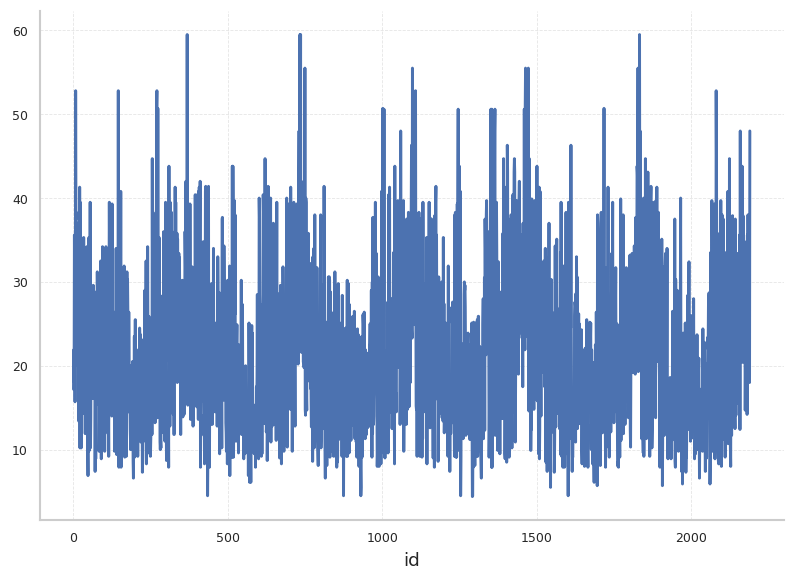

In [14]:
df_train['winddirection_rad'] = np.radians(df_train['winddirection'])
df_train['winddirection_sin'] = np.sin(df_train['winddirection_rad'])

df_train['windspeed'].plot()

In [15]:
# df_train["delta"]=df_train["day"].diff()
# df_train[(df_train["delta"]<0)&(df_train["delta"]>-364)]

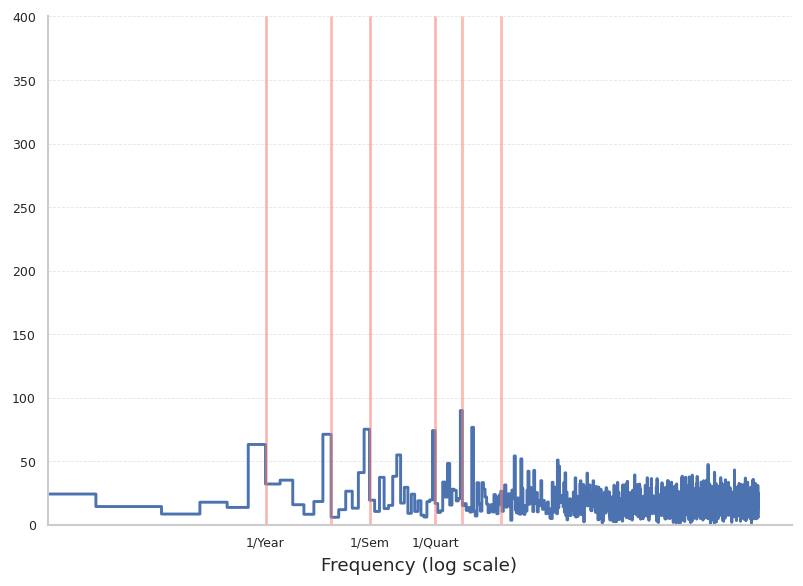

In [16]:
fft = tf.signal.rfft(df_train['rainfall'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df_train['rainfall'])
days_per_year = 365
years_per_dataset = n_samples_h/(days_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.vlines(1.0, 0, 400, color='salmon', alpha=0.5)
plt.vlines(2.0, 0, 400, color='salmon', alpha=0.5)
plt.vlines(3.0, 0, 400, color='salmon', alpha=0.5)
plt.vlines(6.0, 0, 400, color='salmon', alpha=0.5)
plt.vlines(8.0, 0, 400, color='salmon', alpha=0.5)
plt.vlines(12, 0, 400, color='salmon', alpha=0.5)


plt.ylim(0, 400)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 3, 6], labels=['1/Year', '1/Sem', '1/Quart'])
_ = plt.xlabel('Frequency (log scale)')

**Descriptions of Loan Data**

Descriptions for the column names based on the data provided:

* **id**: Unique identifier for each record.
* **person_age**: Age of the individual, categorized into ranges.
* **person_income**: Income of the individual, categorized into income ranges.
* **person_home_ownership**: Homeownership status, which includes categories like 'RENT', 'MORTGAGE', etc.
* **person_emp_length**: Employment length of the individual, categorized into ranges based on years.
* **loan_intent**: The purpose of the loan, with categories such as 'EDUCATION', 'MEDICAL', etc.
* **loan_grade**: The credit grade of the loan, such as 'A', 'B', etc.
* **loan_amnt**: Loan amount, categorized into ranges.
* **loan_int_rate**: Loan interest rate, categorized into percentage ranges.
* **loan_percent_income**: Percentage of the individual’s income that the loan represents, categorized into - ranges.
* **cb_person_default_on_file**: Whether the person has a history of loan default, with values 'true' or 'false'.
* **cb_person_cred_hist_length**: Length of the individual’s credit history, categorized into ranges.
* **loan_status**: with values representing whether the loan status approval( binary values)

The dataset is a about loan applications, including personal, financial, and loan details. It's likely used for predicting whether a person will default on a loan, making it a binary classification problem. The goal is to figure out which applicants are at higher risk of not paying back their loans based on their age, income, employment, loan purpose, credit history, and other related information.

In [49]:
class Config:

    state = 42
    n_splits = 10
    early_stop = 200

    target = 'rainfall'
    train = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/train.csv')
    test = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/test.csv')
    submission = pd.read_csv( "/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/sample_submission.csv",index_col=0)
    train_org = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/Rainfall.csv")

    train_org.rename({"pressure ":"pressure","humidity ":"humidity","cloud ":"cloud","         winddirection":"winddirection"},axis=1,inplace=True)
    train_org["rainfall"] = train_org["rainfall"].map({"yes":1,"no":0})

    original_data = 'Y'
    overwrite_data = 'Y'
    outliers = 'N'
    log_trf = 'N'
    scaler_trf = 'Y'
    feature_eng = 'Y'
    missing = 'Y'
    force_normalization="N"
    impose_normalization="N"
    trg_enc = "N"
    metric_goal="AUC"
    direction_="maximize"
    norm_trf = ['pressure',
                'temparature',
                'dewpoint',
                'humidity',
                'cloud',
                'sunshine',
                'Wdsx',
                'Wdsy',
                'temp_diff',
                'dewpoint_spread',
                'range_dist_cloud',
                'cloud_Humidity_Interaction' ]
    log_trans_cols = []
    force_norm_cols = []
    impose_norm_cols = []
    trg_enc_feat = []

In [50]:
Config.submission

rainfall
id            
2190         0
2191         0
2192         0
2193         0
2194         0
...        ...
2915         0
2916         0
2917         0
2918         0
2919         0

[730 rows x 1 columns]

In [51]:
class Preprocessing():

    def __init__(self):
        self.train = Config.train
        self.test = Config.test
        self.targets = Config.target

        self.prp_data()

    def prp_data(self):

        if Config.original_data == 'Y':
            self.train = pd.concat([self.train, Config.train_org], ignore_index=True).drop_duplicates(ignore_index=True)

        self.train = self.train.drop(['id'], axis=1)
        self.test = self.test.drop(['id'], axis=1)

        self.cat_features = self.train.drop(self.targets, axis=1).select_dtypes(include=['object', 'bool']).columns.tolist()
        self.num_features = self.train.drop(self.targets, axis=1).select_dtypes(exclude=['object', 'bool']).columns.tolist()

        self.train = self.reduce_mem(self.train)
        self.test = self.reduce_mem(self.test)
        return self

    def reduce_mem(self, df):

        numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64', "uint16", "uint32", "uint64"]

        for col in df.columns:
            col_type = df[col].dtypes

            if col_type in numerics:
                c_min = df[col].min()
                c_max = df[col].max()

                if "int" in str(col_type):
                    if c_min >= np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min >= np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min >= np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min >= np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
                else:
                    if c_min >= np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float32)
                    if c_min >= np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)

        return df

In [52]:
class EDA(Config, Preprocessing):

    def __init__(self):
        super().__init__()

        self.data_info()
        self.heatmap()
        self.dist_plots()
        #self.cat_feature_plots()
        self.target_pie()

    def data_info(self):

        for data, label in zip([self.train, self.test], ['Train', 'Test']):
            table_style = [{'selector': 'th:not(.index_name)',
                            'props': [('background-color', 'slategrey'),
                                      ('color', '#FFFFFF'),
                                      ('font-weight', 'bold'),
                                      ('border', '1px solid #DCDCDC'),
                                      ('text-align', 'center')]
                            },
                            {'selector': 'tbody td',
                             'props': [('border', '1px solid #DCDCDC'),
                                       ('font-weight', 'normal')]
                            }]
            print(Style.BRIGHT+Fore.RED+f'\n{label} head\n')
            display(data.head().style.set_table_styles(table_style))

            print(Style.BRIGHT+Fore.RED+f'\n{label} info\n'+Style.RESET_ALL)
            display(data.info())

            print(Style.BRIGHT+Fore.RED+f'\n{label} describe\n')
            display(data.describe().drop(index='count', columns=self.targets, errors = 'ignore').T
                    .style.set_table_styles(table_style).format('{:.3f}'))

            print(Style.BRIGHT+Fore.RED+f'\n{label} missing values\n'+Style.RESET_ALL)
            display(data.isna().sum())
        return self

    def heatmap(self):
        print(Style.BRIGHT+Fore.RED+f'\nCorrelation Heatmap\n')
        plt.figure(figsize=(7,7))
        corr = self.train.select_dtypes(exclude='object').corr(method='pearson')
        sns.heatmap(corr, fmt = '0.2f', cmap = 'Blues', annot=True, cbar=False)
        plt.show()

    def dist_plots(self):

        print(Style.BRIGHT+Fore.RED+f"\nDistribution analysis - Numerical\n")
        df = pd.concat([self.train[self.num_features].assign(Source = 'Train'),
                        self.test[self.num_features].assign(Source = 'Test'),],
                        axis=0, ignore_index = True)

        fig, axes = plt.subplots(len(self.num_features), 2 ,figsize = (18, len(self.num_features) * 6),
                                 gridspec_kw = {'hspace': 0.3,
                                                'wspace': 0.2,
                                                'width_ratios': [0.70, 0.30]
                                               }
                                )
        for i,col in enumerate(self.num_features):
            ax = axes[i,0]
            sns.kdeplot(data = df[[col, 'Source']], x = col, hue = 'Source',
                        palette = ['royalblue', 'tomato'], ax = ax, alpha=0.7, linewidth = 2
                       )
            ax.set(xlabel = '', ylabel = '')
            ax.set_title(f"\n{col}")
            ax.grid('--',alpha=0.7)

            ax = axes[i,1]
            sns.boxplot(data = df, y = col, x=df.Source, width = 0.5,
                        linewidth = 1, fliersize= 1,
                        ax = ax, palette=['royalblue', 'tomato']
                       )
            ax.set_title(f"\n{col}")
            ax.set(xlabel = '', ylabel = '')
            ax.tick_params(axis='both', which='major')
            ax.set_xticklabels(['Train', 'Test'])

        plt.tight_layout()
        plt.show()

    def cat_feature_plots(self):
        print(Style.BRIGHT+Fore.RED+f"\nDistribution analysis - Categorical\n")
        fig, axes = plt.subplots(len(self.cat_features), 2 ,figsize = (18, len(self.cat_features) * 6),
                                 gridspec_kw = {'hspace': 0.5,
                                                'wspace': 0.2,
                                               }
                                )

        for i, col in enumerate(self.cat_features):

            ax = axes[i,0]
            sns.barplot(data=self.train[col].value_counts().nlargest(10).reset_index(), x=col, y='count', ax=ax, color='royalblue', alpha=0.7)
            ax.set(xlabel = '', ylabel = '')
            ax.set_title(f"\n{col} Train")

            ax = axes[i,1]
            sns.barplot(data=self.test[col].value_counts().nlargest(10).reset_index(), x=col, y='count', ax=ax, color='tomato', alpha=0.7)
            ax.set(xlabel = '', ylabel = '')
            ax.set_title(f"\n{col} Test")

        plt.tight_layout()
        plt.show()

    def target_pie(self):
        print(Style.BRIGHT+Fore.RED+f"\nTarget feature distribution\n")
        targets = self.train[self.targets]
        plt.figure(figsize=(6, 6))
        plt.pie(targets.value_counts(), labels=targets.value_counts().index, autopct='%1.2f%%', colors=palette_9)
        plt.show()

## 1.0 EDA


Train head




Train info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2556 entries, 0 to 2555
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   day            2556 non-null   int32  
 1   pressure       2556 non-null   float32
 2   maxtemp        2556 non-null   float32
 3   temparature    2556 non-null   float32
 4   mintemp        2556 non-null   float32
 5   dewpoint       2556 non-null   float32
 6   humidity       2556 non-null   float32
 7   cloud          2556 non-null   float32
 8   sunshine       2556 non-null   float32
 9   winddirection  2555 non-null   float32
 10  windspeed      2555 non-null   float32
 11  rainfall       2556 non-null   int32  
dtypes: float32(10), int32(2)
memory usage: 119.9 KB


None


Train describe




Train missing values



day              0
pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    1
windspeed        1
rainfall         0
dtype: int64


Test head




Test info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   day            730 non-null    int32  
 1   pressure       730 non-null    float32
 2   maxtemp        730 non-null    float32
 3   temparature    730 non-null    float32
 4   mintemp        730 non-null    float32
 5   dewpoint       730 non-null    float32
 6   humidity       730 non-null    float32
 7   cloud          730 non-null    float32
 8   sunshine       730 non-null    float32
 9   winddirection  729 non-null    float32
 10  windspeed      730 non-null    float32
dtypes: float32(10), int32(1)
memory usage: 31.5 KB


None


Test describe




Test missing values



day              0
pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    1
windspeed        0
dtype: int64


Correlation Heatmap



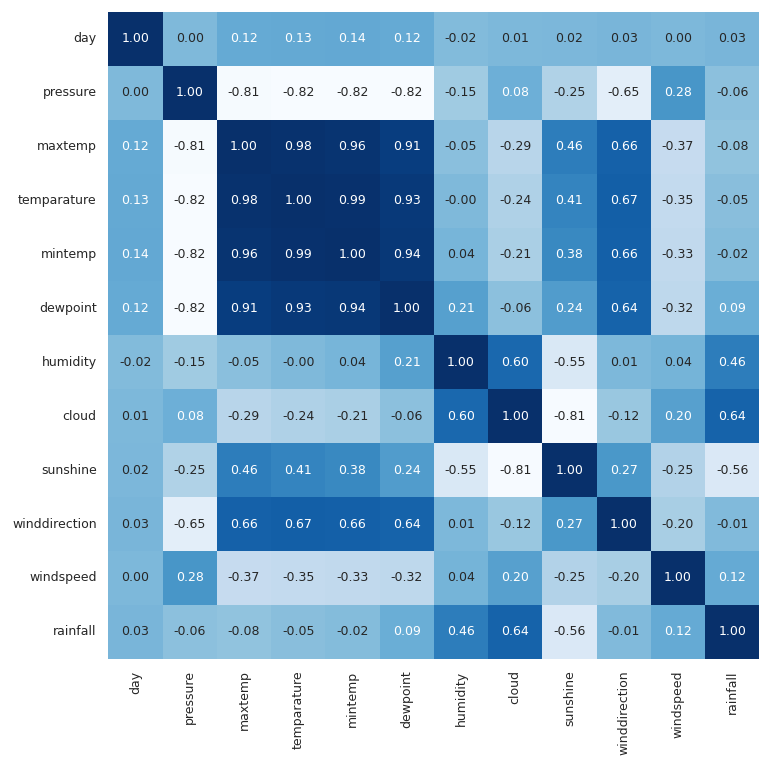


Distribution analysis - Numerical



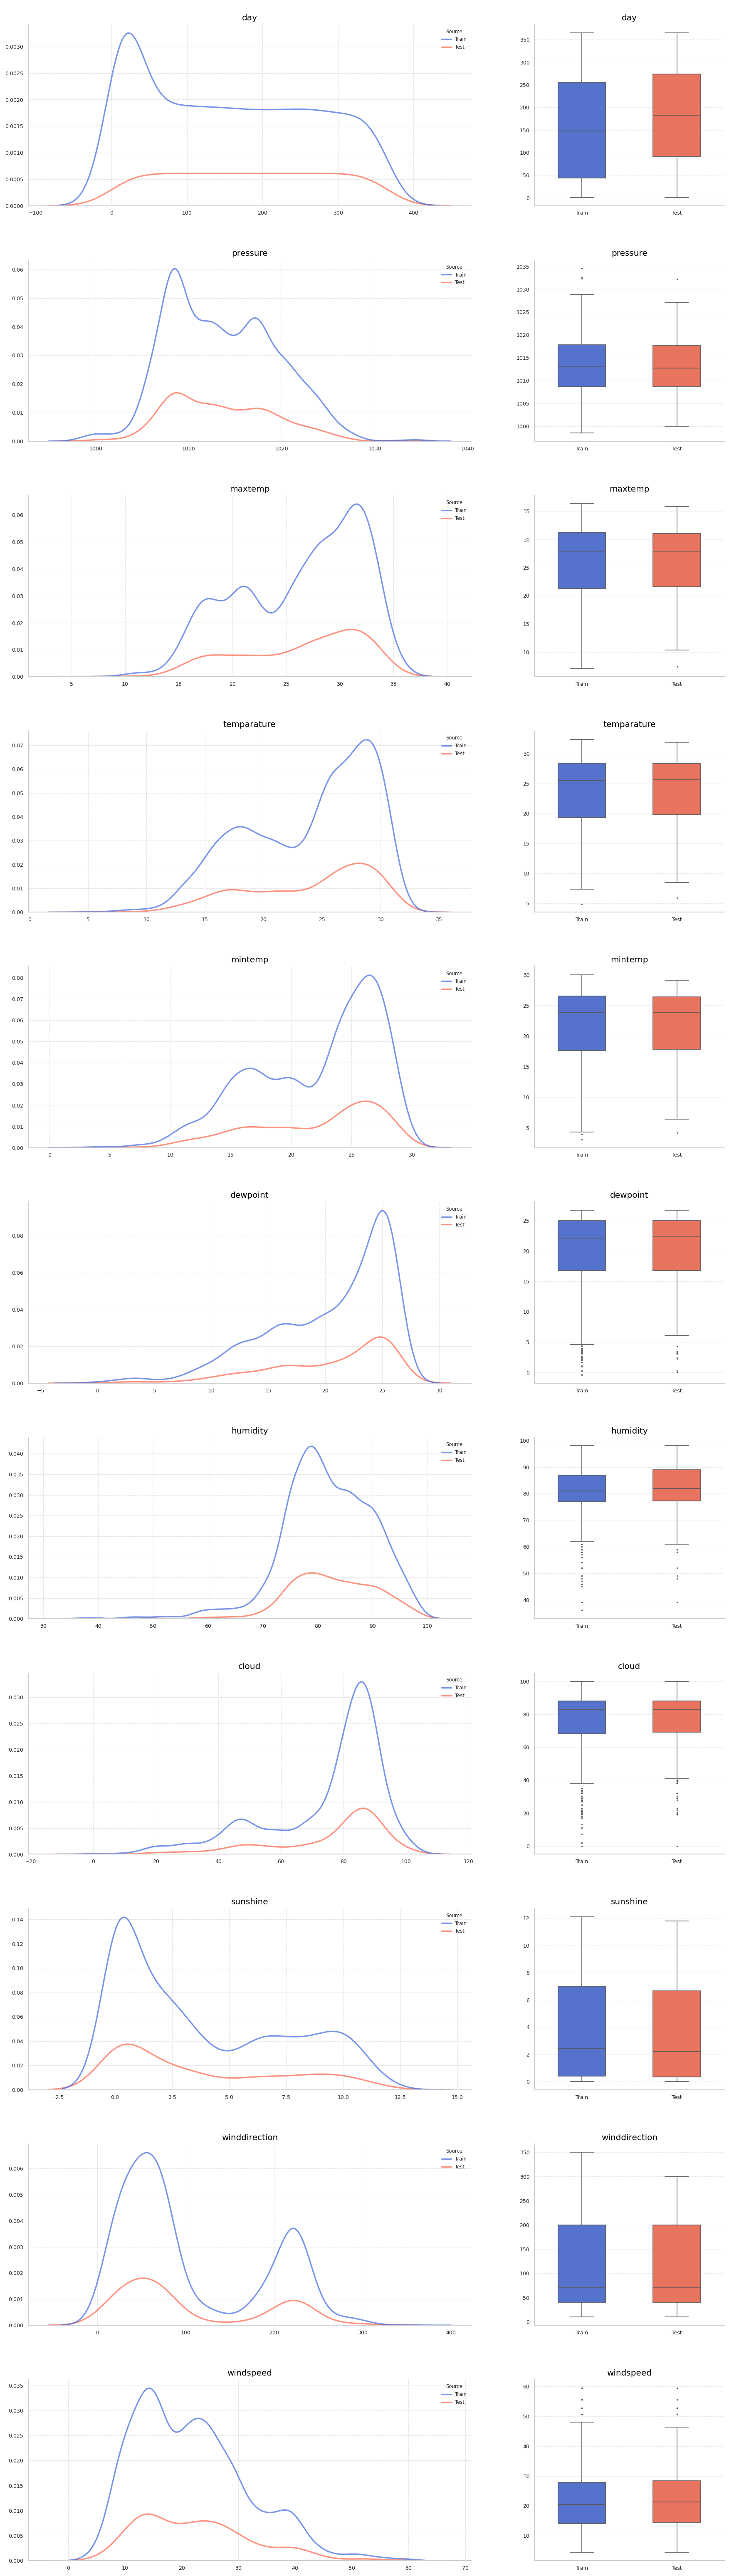


Target feature distribution



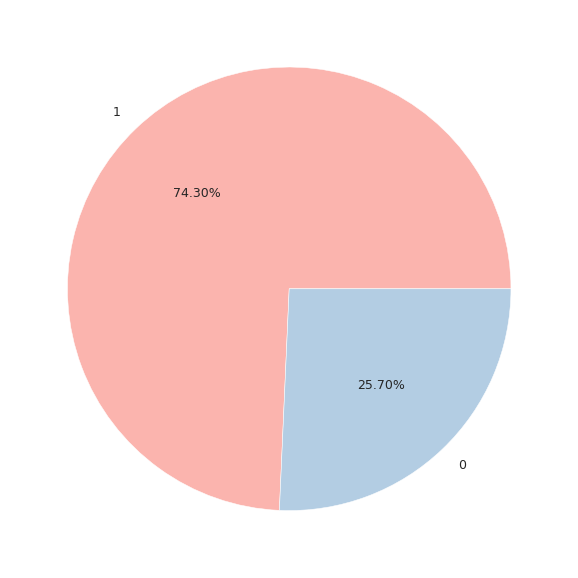

In [53]:
eda = EDA()

## 2.0 Data Transformation and Feature Negeneering:

In [54]:
class Transform(Config, Preprocessing):

    def __init__(self):
        super().__init__()

        if self.missing == 'Y':
            self.missing_values()

        self.train_raw = self.train.copy()

        if self.overwrite_data == 'Y':
            self.train = self.overwrite(self.train)
            self.test = self.overwrite(self.test)

        if self.feature_eng == 'Y':
            self.train = self.new_features(self.train)
            self.test = self.new_features(self.test)
            self.train_raw = self.new_features(self.train_raw)


        self.train.drop(["day","Wdx","Wdy","maxtemp","mintemp","windspeed"], axis=1, inplace=True)
        self.test.drop(["day","Wdx","Wdy","maxtemp","mintemp","windspeed"], axis=1, inplace=True)

        self.num_features = self.train.drop(self.target, axis=1).select_dtypes(exclude=['object', 'bool']).columns.tolist()
        self.cat_features = self.train.drop(self.target, axis=1).select_dtypes(include=['object', 'bool']).columns.tolist()

        if self.outliers == 'Y':
            self.remove_outliers()

        if self.log_trf == 'Y':
            self.log_transformation()

        if self.force_normalization == 'Y':
            self.forced_norm_transformation()

        if self.impose_normalization == 'Y':
            self.impose_normalization_transformation()

        if self.trg_enc == 'Y':
            self.target_encoding()

        if self.scaler_trf == 'Y':
            self.scaler()

        if self.outliers == 'Y' or self.log_trf == 'Y' or self.scaler_trf =='Y':
            self.distribution()


    def __call__(self):

        self.train[self.cat_features] = self.train[self.cat_features].astype('category')
        self.test[self.cat_features] = self.test[self.cat_features].astype('category')
        data = pd.concat([self.test, self.train])
        self.train_enc, self.test_enc = self.encode(data)

        self.cat_features_card = []
        for f in self.cat_features:
            self.cat_features_card.append(1 + data[f].max())

        self.y = self.train[self.target]
        self.train = self.train.drop(self.target, axis=1)
        self.train_enc = self.train_enc.drop(self.target, axis=1)

 #       scaler = StandardScaler()
 #       self.train_enc[self.num_features] = scaler.fit_transform(self.train_enc[self.num_features])
 #       self.test_enc[self.num_features] = scaler.transform(self.test_enc[self.num_features])

        return self.train, self.train_enc, self.y, self.test, self.test_enc, self.cat_features


    def encode(self, data):

        oe = OrdinalEncoder()
        data[self.cat_features] = oe.fit_transform(data[self.cat_features]).astype('int')

        train_enc = data[~data[self.target].isna()]
        test_enc = data[data[self.target].isna()].drop(self.target, axis=1)
        return train_enc, test_enc

    def overwrite(self, df):

        # Iterate through the rows, starting from the second row
        for i in range(1, len(df)):

            # Calculate the difference between the current day and the previous day
            diff = df.loc[i, 'day'] - df.loc[i-1, 'day']

            # If the difference is greater than 1, replace the current day with the previous day plus 1
            if diff > -360:
                df.loc[i, 'day'] = df.loc[i-1, 'day'] + 1

        return df

    def new_features(self, df):

        # Wind Speed and direction:
        #Replace Some entries that appears wrong in the dataset:
        wv = df['windspeed']

        # Convert to radians.
        wd_rad = df.pop('winddirection')*np.pi / 180

        # Calculate the wind x and y components.
        df['Wdx'] = np.cos(wd_rad)
        df['Wdy'] = np.sin(wd_rad)

        # Calculate the wind x and y components.
        df['Wdsx'] = wv*np.cos(wd_rad)
        df['Wdsy'] = wv*np.sin(wd_rad)

        # Temporal Features:
        # Annual Seasonalities:
        df['Year_sin'] = np.sin(df['day'] * (2 * np.pi / 365))
        df['Year_cos'] = np.cos(df['day'] * (2 * np.pi / 365))
        # Semester Seasonalities:
        df['sem_sin'] = np.sin(df['day'] * (2 * np.pi / (365/ 2)))
        df['sem_cos'] = np.cos(df['day'] * (2 * np.pi / (365/ 2)))
        # 4-time a year Seasonalities:
        df['m4_sin'] = np.sin(df['day'] * (2 * np.pi / (365/ 3)))
        df['m4_cos'] = np.cos(df['day'] * (2 * np.pi / (365/ 3)))
        # 6-time a year Seasonalities:
        df['m6_sin'] = np.sin(df['day'] * (2 * np.pi / (365/ 6)))
        df['m6_cos'] = np.cos(df['day'] * (2 * np.pi / (365/ 6)))
        # 8-time a year Seasonalities:
        df['m8_sin'] = np.sin(df['day'] * (2 * np.pi / (365/ 8)))
        df['m8_cos'] = np.cos(df['day'] * (2 * np.pi / (365/ 8)))

        # Month of the year:
        # Define the number of days in each month
        df["temp_diff"] = (df["maxtemp"] - df["mintemp"])
        df["dewpoint_spread"] = (df["temparature"] - df["dewpoint"])
        df["range_dist_cloud"] = (df["temp_diff"])*((df["cloud"]**2))

        # Interaction Feature: Pressure & Humidity - Multiply to capture pressure-humidity effects
        df['cloud_Humidity_Interaction'] = np.log1p(((df['cloud'] + df['humidity']/10)+df["dewpoint_spread"])/(1+100*df["sunshine"]/12))

        return df

    def log_transformation(self):

        self.train[self.log_trans_cols] = np.log1p(self.train[self.log_trans_cols])
        self.test[self.log_trans_cols] = np.log1p(self.test[self.log_trans_cols])

        return self

    def forced_norm_transformation(self):

        self.train[self.force_norm_cols] = np.sqrt(self.train[self.force_norm_cols]+0.1)
        self.test[self.force_norm_cols] = np.sqrt(self.test[self.force_norm_cols]+0.1)

        return self

    def impose_normalization_transformation(self):

        scaler = QuantileTransformer(output_distribution='normal',subsample=20_000,random_state=42)
        self.train[self.impose_norm_cols] = scaler.fit_transform(self.train[self.impose_norm_cols])
        self.test[self.impose_norm_cols] = scaler.transform(self.test[self.impose_norm_cols])

        return self


    def distribution(self):

        print(Style.BRIGHT+Fore.RED+f'\nHistograms of distribution\n')
        fig, axes = plt.subplots(nrows=len(self.num_features), ncols=2, figsize=(15, len(self.num_features)*5))

        for (ax_r, ax_n), col in zip(axes, self.num_features):

            ax_r.set_title(f'{col} ($\mu=$ {self.train_raw[col].mean():.2f} and $\sigma=$ {self.train_raw[col].std():.2f} )')
            ax_r.hist(self.train_raw[col], bins=30, color='tomato',alpha=0.7)
            ax_r.axvline(self.train_raw[col].mean(), color='r', label='Mean')
            ax_r.axvline(self.train_raw[col].median(), color='y', linestyle='--', label='Median')
            ax_r.legend()

            ax_n.set_title(f'{col} Normalized ($\mu=$ {self.train[col].mean():.2f} and $\sigma=$ {self.train[col].std():.2f} )')
            ax_n.hist(self.train[col], bins=30, color='royalblue',alpha=0.7)
            ax_n.axvline(self.train[col].mean(), color='r', label='Mean')
            ax_n.axvline(self.train[col].median(), color='y', linestyle='--', label='Median')
            ax_n.legend()

    def remove_outliers(self):
        Q1 = self.train[self.targets].quantile(0.25)
        Q3 = self.train[self.targets].quantile(0.75)
        IQR = Q3 - Q1
        lower_limit = Q1 - 1.5*IQR
        upper_limit = Q3 + 1.5*IQR
        self.train = self.train[(self.train[self.targets] >= lower_limit) & (self.train[self.targets] <= upper_limit)]
        self.train.reset_index(drop=True, inplace=True)

    def scaler(self):
        scaler = StandardScaler()
        #to_drop = ["Wdx",	"Wdy",	"Wdsx",	"Wdsy",	"Year_sin",	"Year_cos",	"sem_sin",	"sem_cos",	"m4_sin",	"m4_cos",	"m6_sin",	"m6_cos",	"m8_sin",	"m8_cos"]
        self.train[self.norm_trf] = scaler.fit_transform(self.train[self.norm_trf])
        self.test[self.norm_trf] = scaler.transform(self.test[self.norm_trf])
        return self

    def missing_values(self):

        self.train[self.num_features] = self.train[self.num_features].fillna(self.train[self.num_features].median())
        self.test[self.num_features] = self.test[self.num_features].fillna(self.test[self.num_features].median())
        for column in self.cat_features:
            self.train[column] = self.train[column].fillna(self.train[column].mode()[0])
            self.test[column] = self.test[column].fillna(self.test[column].mode()[0])
        return self

    def target_encoding(self):
        te = TargetEncoder()
        self.train[self.trg_enc_feat] = te.fit_transform(self.train[self.trg_enc_feat],self.train[self.target])
        self.test[self.trg_enc_feat] = te.transform(self.test[self.trg_enc_feat])

        for a in self.cat_features:
            self.cat_features.remove(a)

        return self

    @property
    def cat_features(self):
        return self._cat_features

    @cat_features.setter
    def cat_features(self, cat_features):
        self._cat_features = cat_features

    @property
    def num_features(self):
        return self._num_features

    @num_features.setter
    def num_features(self, num_features):
        self._num_features = num_features

    @property
    def cat_features_card(self):
        return self._cat_features_card

    @cat_features_card.setter
    def cat_features_card(self, cat_features_card):
        self._cat_features_card = cat_features_card

    @property
    def train(self):
        return self._train

    @train.setter
    def train(self, train):
        self._train = train

    @property
    def direction(self):
        return self._direction

    @direction.setter
    def direction(self, direction):
        self._direction= direction


Histograms of distribution



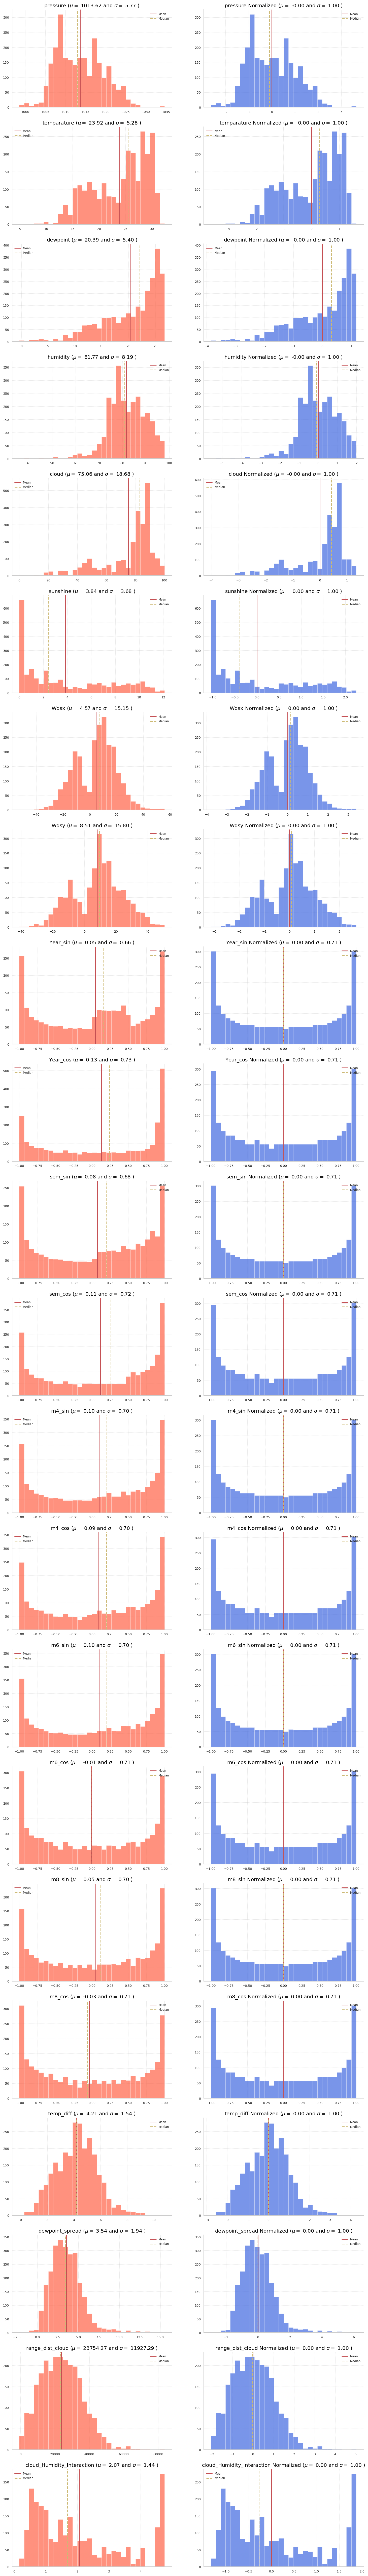

In [55]:
t = Transform()
X, X_enc, y, test, test_enc, cat_features = t()

In [56]:
X_enc.describe().T
#X_enc.columns

count          mean       std       min  \
pressure                    2556.0 -2.984896e-09  1.000196 -2.621764   
temparature                 2556.0 -1.492448e-08  1.000196 -3.601971   
dewpoint                    2556.0 -1.193958e-08  1.000195 -3.852658   
humidity                    2556.0 -2.984896e-09  1.000194 -5.591897   
cloud                       2556.0 -8.954689e-09  1.000195 -4.019604   
sunshine                    2556.0  2.089427e-08  1.000195 -1.044309   
Wdsx                        2556.0  1.492448e-08  1.000196 -3.788323   
Wdsy                        2556.0  8.954689e-09  1.000196 -3.145310   
Year_sin                    2556.0  6.734490e-06  0.707107 -0.999991   
Year_cos                    2556.0  3.911783e-04  0.707383 -0.999963   
sem_sin                     2556.0  1.346698e-05  0.707107 -0.999991   
sem_cos                     2556.0  3.910045e-04  0.707383 -0.999963   
m4_sin                      2556.0  2.019549e-05  0.707108 -0.999991   
m4_cos                      2556.0  3.907147e-04  0.707383 -0.999963   
m6_sin                      2556.0  4.033713e-05  0.707110 -0.999991   
m6_cos                      2556.0  3.891513e-04  0.707380 -0.999963   
m8_sin                      2556.0  5.370844e-05  0.707112 -0.999991   
m8_cos                      2556.0  3.875323e-04  0.707378 -0.999963   
temp_diff                   2556.0  3.731120e-09  1.000194 -2.792613   
dewpoint_spread             2556.0  7.462241e-09  1.000196 -2.949999   
range_dist_cloud            2556.0  8.954689e-09  1.000195 -2.049748   
cloud_Humidity_Interaction  2556.0  2.984896e-09  1.000195 -1.332517   

                                 25%           50%       75%       max  
pressure                   -0.870720 -1.078824e-01  0.724297  3.636930  
temparature                -0.875442  2.984808e-01  0.847573  1.604943  
dewpoint                   -0.664954  3.173044e-01  0.854766  1.169830  
humidity                   -0.582807 -9.411523e-02  0.638922  1.982825  
cloud                      -0.378278  4.249554e-01  0.692700  1.335287  
sunshine                   -0.935557 -3.917993e-01  0.858844  2.245427  
Wdsx                       -0.845015  1.539334e-01  0.671714  3.390395  
Wdsy                       -0.781715  7.201163e-02  0.663782  2.671151  
Year_sin                   -0.705584 -2.449294e-16  0.705584  0.999991  
Year_cos                   -0.708627  4.303538e-03  0.702527  1.000000  
sem_sin                    -0.705584 -4.898587e-16  0.705584  0.999991  
sem_cos                    -0.708627  4.303538e-03  0.702527  1.000000  
m4_sin                     -0.705584 -7.347881e-16  0.705584  0.999991  
m4_cos                     -0.708627  4.303538e-03  0.702527  1.000000  
m6_sin                     -0.705584 -1.469576e-15  0.705584  0.999991  
m6_cos                     -0.708627  4.303538e-03  0.702527  1.000000  
m8_sin                     -0.705584 -1.959435e-15  0.705584  0.999991  
m8_cos                     -0.708627  4.303538e-03  0.702527  1.000000  
temp_diff                  -0.719294 -6.590188e-03  0.641322  4.269630  
dewpoint_spread            -0.686972 -6.978410e-02  0.547405  6.153538  
range_dist_cloud           -0.758129 -4.379622e-02  0.670537  5.021475  
cloud_Humidity_Interaction -0.852408 -2.758679e-01  0.758429  1.871434

Text(0.5, 1.0, 'Time of day signal')

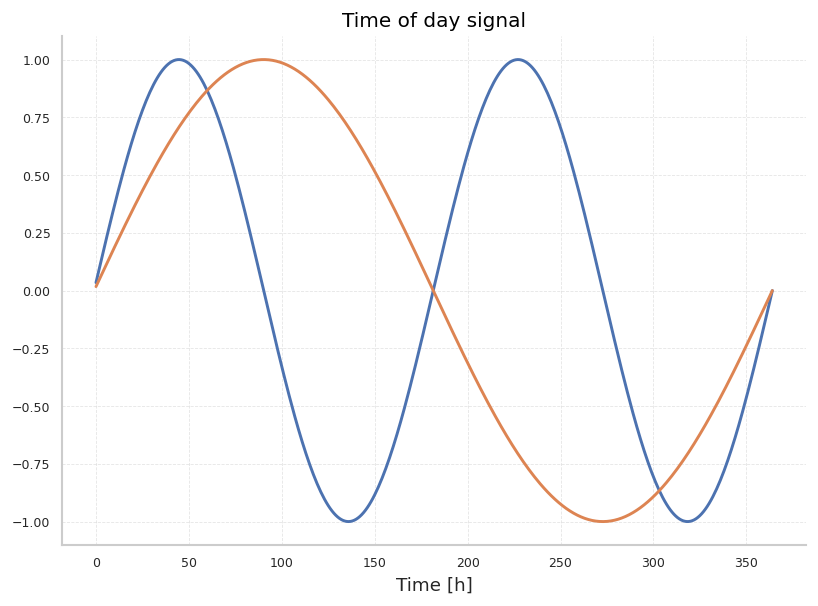

In [57]:
plt.plot(np.array(X_enc['sem_sin'])[:365])
plt.plot(np.array(X_enc['Year_sin'])[:365])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

(-3.788323402404785,
 3.390394687652588,
 -3.1453099250793457,
 2.6711513996124268)

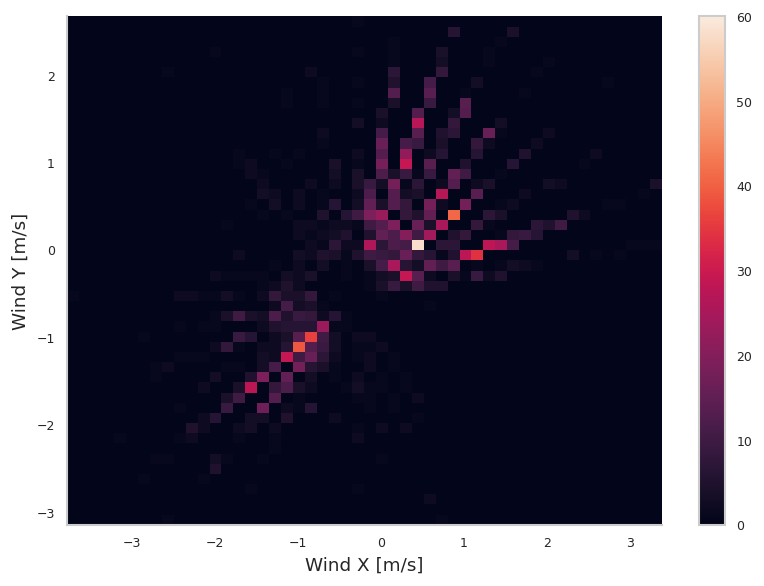

In [58]:
plt.hist2d(X_enc['Wdsx'], X_enc['Wdsy'], bins=(50, 50), vmax=60)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

In [59]:
X.shape, X_enc.shape, test.shape, test_enc.shape

((2556, 22), (2556, 22), (730, 22), (730, 22))

In [61]:
X_enc_ext = X_enc.copy()
X_enc_ext["rainfall"] = y
X_enc_ext.columns

Index(['pressure', 'temparature', 'dewpoint', 'humidity', 'cloud', 'sunshine',
       'Wdsx', 'Wdsy', 'Year_sin', 'Year_cos', 'sem_sin', 'sem_cos', 'm4_sin',
       'm4_cos', 'm6_sin', 'm6_cos', 'm8_sin', 'm8_cos', 'temp_diff',
       'dewpoint_spread', 'range_dist_cloud', 'cloud_Humidity_Interaction',
       'rainfall'],
      dtype='object')

In [62]:
#X_enc_ext[["windspeed","humidity"]].describe()

In [63]:
# columns_delta = [ 'rainfall',"temparature"]

# for col in columns_delta:
#   for delta in range(1, 8):
#     verify_lag = X_enc_ext[col].shift(delta).fillna(1)
#     df_corr = pd.concat([X_enc_ext[["rainfall"]],verify_lag],axis=1)
#     corr_verify = df_corr.corr().iloc[0,1]

#     print(f"{col} with lag {delta} corr: {corr_verify}")

In [64]:
# X_enc_ext["temp_diff"] = (X_enc_ext["maxtemp"] - X_enc_ext["mintemp"])#/X_enc_ext["temparature"]
# X_enc_ext["dewpoint_spread"] = (X_enc_ext["temparature"] - X_enc_ext["dewpoint"])#/X_enc_ext["temparature"]
# X_enc_ext["range_dist_cloud"] = (X_enc_ext["temp_diff"])*((X_enc_ext["cloud"]**2))



# # Interaction Feature: Pressure & Humidity - Multiply to capture pressure-humidity effects
# X_enc_ext['cloud_Humidity_Interaction'] = np.log1p(((X_enc_ext['cloud'] + X_enc_ext['humidity']/10)+X_enc_ext["dewpoint_spread"])/(1+100*X_enc_ext["sunshine"]/12))

# # Interaction Feature: Wind & Cloud Cover - Wind effect on cloud cover
# X_enc_ext['Wind_Cloud_Interaction'] = X_enc_ext['windspeed'] * 0.25*X_enc_ext['cloud']

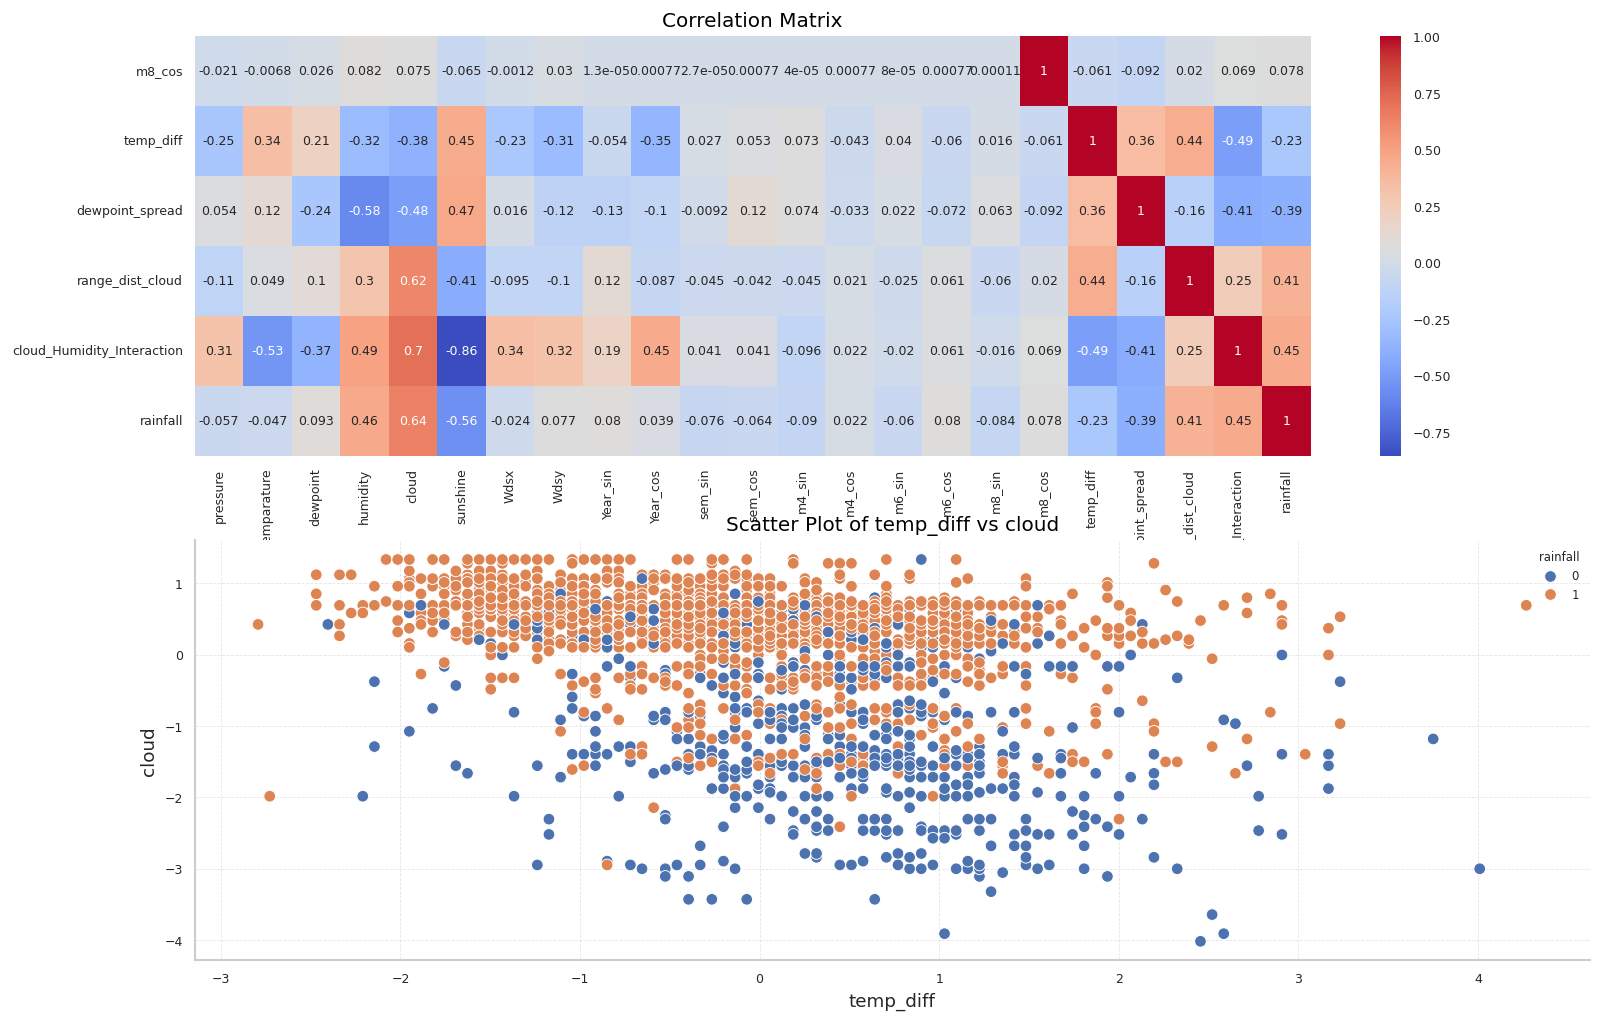

<Figure size 1200x720 with 0 Axes>

In [65]:
#Calculate the correlation between the numerical features and the target variable
correlation_matrix = X_enc_ext.corr()
fig,ax=plt.subplots(2,1,figsize=(15,10))

# Plot the heatmap
sns.heatmap(correlation_matrix.iloc[-6:,:], annot=True, cmap='coolwarm', ax=ax[0])
ax[0].set_title('Correlation Matrix')

# Create a scatter plot of `humidity` vs `sunshine`
x1='temp_diff'
x2='cloud'
plt.figure(figsize=(10, 6))
sns.scatterplot(x=x1, y=x2, hue='rainfall', data=X_enc_ext,ax=ax[1])
ax[1].set_title(f'Scatter Plot of {x1} vs {x2}')
ax[1].set_xlabel(x1)
ax[1].set_ylabel(x2)
plt.tight_layout()
plt.show()

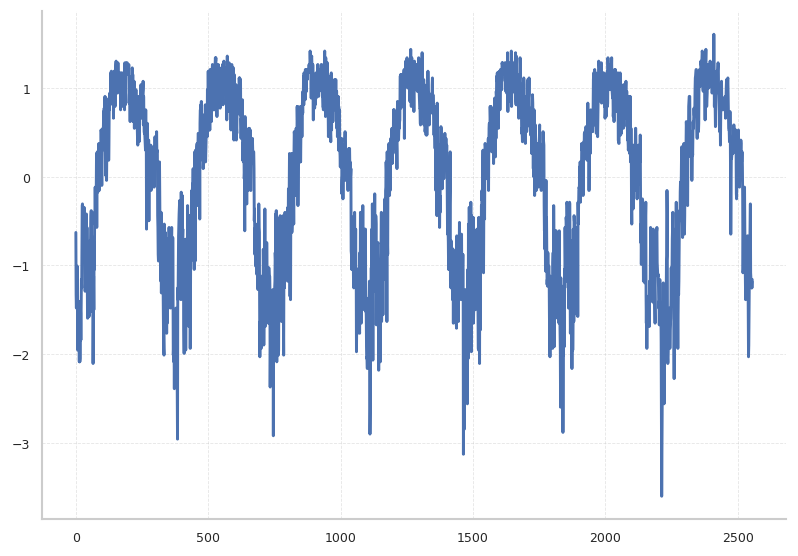

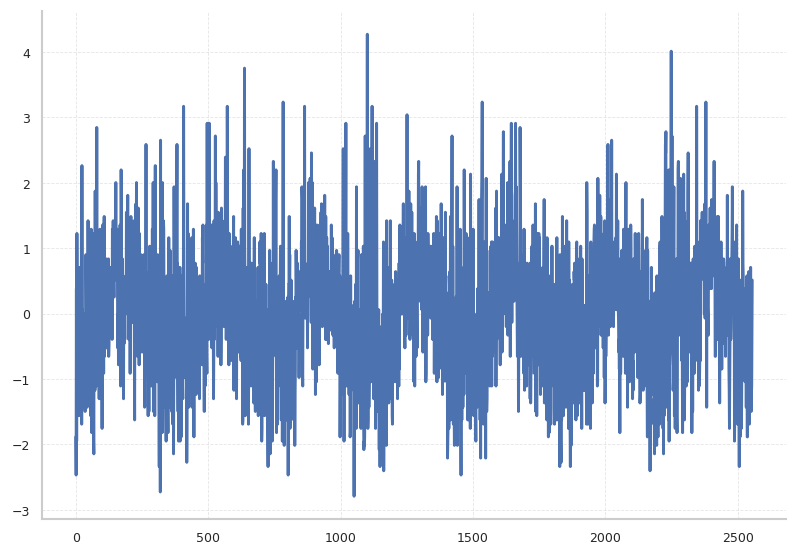

pressure                      0
temparature                   0
dewpoint                      0
humidity                      0
cloud                         0
sunshine                      0
Wdsx                          0
Wdsy                          0
Year_sin                      0
Year_cos                      0
sem_sin                       0
sem_cos                       0
m4_sin                        0
m4_cos                        0
m6_sin                        0
m6_cos                        0
m8_sin                        0
m8_cos                        0
temp_diff                     0
dewpoint_spread               0
range_dist_cloud              0
cloud_Humidity_Interaction    0
rainfall                      0
dtype: int64

In [66]:
X_enc_ext.temparature.plot()
plt.show()
X_enc_ext.temp_diff.plot()
plt.show()
X_enc_ext.isna().sum()
#imputer = MixedDataImputer(X_enc, test_enc)

In [67]:
#train_df_imputed, test_df_imputed = imputer.transform()
X_enc_ext.columns

Index(['pressure', 'temparature', 'dewpoint', 'humidity', 'cloud', 'sunshine',
       'Wdsx', 'Wdsy', 'Year_sin', 'Year_cos', 'sem_sin', 'sem_cos', 'm4_sin',
       'm4_cos', 'm6_sin', 'm6_cos', 'm8_sin', 'm8_cos', 'temp_diff',
       'dewpoint_spread', 'range_dist_cloud', 'cloud_Humidity_Interaction',
       'rainfall'],
      dtype='object')

In [68]:
#X_enc_ext.isna().sum()

## 3.0 Advanced Feature Engeneering

In [69]:
X_enc.sample(3)

pressure  temparature  dewpoint  humidity     cloud  sunshine      Wdsx  \
715   1.001697    -1.689614 -0.887351 -0.338461  0.746249 -1.044309  0.848586   
278   0.550926     0.203810 -0.016293 -1.438018  0.157211  0.396650  0.239778   
1723  0.672288     0.771837  1.095697  0.272404  0.746249 -0.446175 -1.199136   

          Wdsy  Year_sin  Year_cos   sem_sin   sem_cos    m4_sin    m4_cos  \
715   0.775345 -0.238673  0.971100 -0.463550  0.886071 -0.661635  0.749826   
278   0.360158 -0.995919  0.090252 -0.179767 -0.983709  0.963471 -0.267814   
1723 -0.387425 -0.985948 -0.167052  0.329408 -0.944188  0.875892  0.482508   

        m6_sin    m6_cos    m8_sin    m8_cos  temp_diff  dewpoint_spread  \
715  -0.992222  0.124479 -0.936881 -0.349647  -0.913668        -2.127080   
278  -0.516062 -0.856551  0.661635  0.749826   0.122992         0.598838   
1723  0.845249 -0.534373 -0.974100  0.226116   1.030068        -0.944134   

      range_dist_cloud  cloud_Humidity_Interaction  
715          -0.132116                    1.745919  
278           0.252858                   -0.682157  
1723          1.860594                   -0.181336

In [70]:
X_enc_y = pd.concat([X_enc, y], axis=1)
X_enc_y.sample(3)

pressure  temparature  dewpoint  humidity     cloud  sunshine      Wdsx  \
2233 -0.194568    -0.155941  0.131973  0.883268  0.050113 -0.092732 -0.934636   
1935 -0.246577     0.279547  0.335838  0.883268  0.264309 -0.283048  0.462134   
2495  1.261754    -0.193809 -0.479622 -1.071499 -0.753120  0.124771  1.535037   

          Wdsy  Year_sin  Year_cos   sem_sin   sem_cos    m4_sin    m4_cos  \
2233 -0.760059  0.687053  0.726608  0.998435  0.055917  0.763889 -0.645348   
1935  0.075427  0.942761 -0.333469 -0.628763 -0.777597 -0.523416  0.852078   
2495  0.101875 -0.849817  0.527078 -0.895839 -0.444378 -0.094537 -0.995521   

        m6_sin    m6_cos    m8_sin    m8_cos  temp_diff  dewpoint_spread  \
2233 -0.985948 -0.167052 -0.221922  0.975065   0.252574        -0.789838   
1935 -0.891981  0.452072  0.409356 -0.912375  -1.691162        -0.172649   
2495  0.188227  0.982126 -0.963471 -0.267814  -0.136173         0.804567   

      range_dist_cloud  cloud_Humidity_Interaction  rainfall  
2233          0.236087                   -0.499502         0  
1935         -1.133275                   -0.353515         1  
2495         -0.743840                   -0.680576         0

In [71]:
X_enc_y.info()
t.cat_features

<class 'pandas.core.frame.DataFrame'>
Index: 2556 entries, 0 to 2555
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   pressure                    2556 non-null   float32
 1   temparature                 2556 non-null   float32
 2   dewpoint                    2556 non-null   float32
 3   humidity                    2556 non-null   float32
 4   cloud                       2556 non-null   float32
 5   sunshine                    2556 non-null   float32
 6   Wdsx                        2556 non-null   float32
 7   Wdsy                        2556 non-null   float32
 8   Year_sin                    2556 non-null   float64
 9   Year_cos                    2556 non-null   float64
 10  sem_sin                     2556 non-null   float64
 11  sem_cos                     2556 non-null   float64
 12  m4_sin                      2556 non-null   float64
 13  m4_cos                      2556 non-n

[]

In [72]:
class plot_class():

    def __init__(self,df, target_variable, features_cat,features_num):
      self.df = df
      self.target_variable = target_variable
      self.features_cat = features_cat
      self.features_num = features_num

    @classmethod
    def plot_categorical_features(cls, df, target_variable, features_cat, features_num):
        """
        Plots the frequency of the target variable for each value of multiple categorical features.

        Args:
          df: Pandas DataFrame containing the data.
          target_variable: Name of the target variable column in the DataFrame.
          features: List of names of the categorical feature columns to plot.
        """

        num_features = len(features_cat)
        if num_features>0:
          num_rows = (num_features + 1) // 2  # Calculate the number of rows needed

          fig, axes = plt.subplots(num_rows, 2, figsize=(12, 4 * num_rows))
          axes = axes.flatten()  # Flatten the axes array for easier iteration

          for i, feature in enumerate(features_cat):
              cross_tab = pd.crosstab(df[feature], df[target_variable])
              cross_tab.plot(kind='bar', stacked=False, position=0.3, width=0.4, ax=axes[i],colormap=palette_1, alpha=0.6)
              axes[i].set_xlabel(feature)
              axes[i].set_ylabel('Frequency')
              axes[i].set_title(f'Frequency of {target_variable} by {feature}')

          # Hide any unused subplots
          for i in range(num_features, len(axes)):
              axes[i].axis('off')

          plt.tight_layout()
          plt.show()

        else:
          print("No categorical features to plot.")

        return cls(df, target_variable, features_cat, features_num)

    @classmethod
    def plot_numerical_features(cls, df, target_variable, features_cat, features_num):
        """
        Generates violin plots for numerical features, showing the distribution for each target class.

        Args:
          df: Pandas DataFrame containing the data.
          target_variable: Name of the target variable column in the DataFrame.
          features: List of names of the numerical feature columns to plot.
        """

        num_features = len(features_num)
        num_rows = (num_features + 1) // 2  # Calculate the number of rows needed

        fig, axes = plt.subplots(num_rows, 2, figsize=(12, 4 * num_rows))
        axes = axes.flatten()  # Flatten the axes array for easier iteration

        for i, feature in enumerate(features_num):
            sns.violinplot(x=target_variable, y=feature, data=df, ax=axes[i],
                           hue=target_variable,  # Use 'hue' to color by target class
                           palette=palette_9)
            axes[i].set_xlabel(target_variable)
            axes[i].set_ylabel(feature)
            axes[i].set_title(f'Distribution of {feature} by {target_variable}')

        # Hide any unused subplots
        for i in range(num_features, len(axes)):
            axes[i].axis('off')

        plt.tight_layout()
        plt.show()

        return cls(df, target_variable, features_cat, features_num)

    def scatter_comp(self, feat_01, feat_02, hue_def):
        """
        Generates a scatter plot between two features, colored by a third
        categorical feature using Seaborn.

        Args:
          df: Pandas DataFrame containing the data.
          x_feature: Name of the feature to plot on the x-axis.
          y_feature: Name of the feature to plot on the y-axis.
          color_feature: Name of the categorical feature to use for coloring.
        """
        fig, ax = plt.subplots(figsize=(8, 6))
        sns.scatterplot(
            x=feat_01,
            y=feat_02,
            hue=hue_def,  # Use 'hue' for color encoding
            data=self.df,
            ax=ax
        )

        plt.xlabel(feat_01)
        plt.ylabel(feat_02)
        plt.title(f'ScatterPlot of {feat_01} vs. {feat_02} colored by {hue_def}')
        plt.show()

    def heatmap_corr(self):
        print(Style.BRIGHT+Fore.RED+f'\nCorrelation Heatmap\n')
        plt.figure(figsize=(7,7))
        corr = self.df.select_dtypes(exclude='int').corr(method='pearson')
        sns.heatmap(corr, fmt = '0.2f', cmap = "Reds", annot=True, cbar=False)
        plt.show()

In [73]:
plot_instance = plot_class.plot_categorical_features(df=X_enc_y, target_variable="rainfall", features_cat=t.cat_features, features_num=t.num_features);

No categorical features to plot.


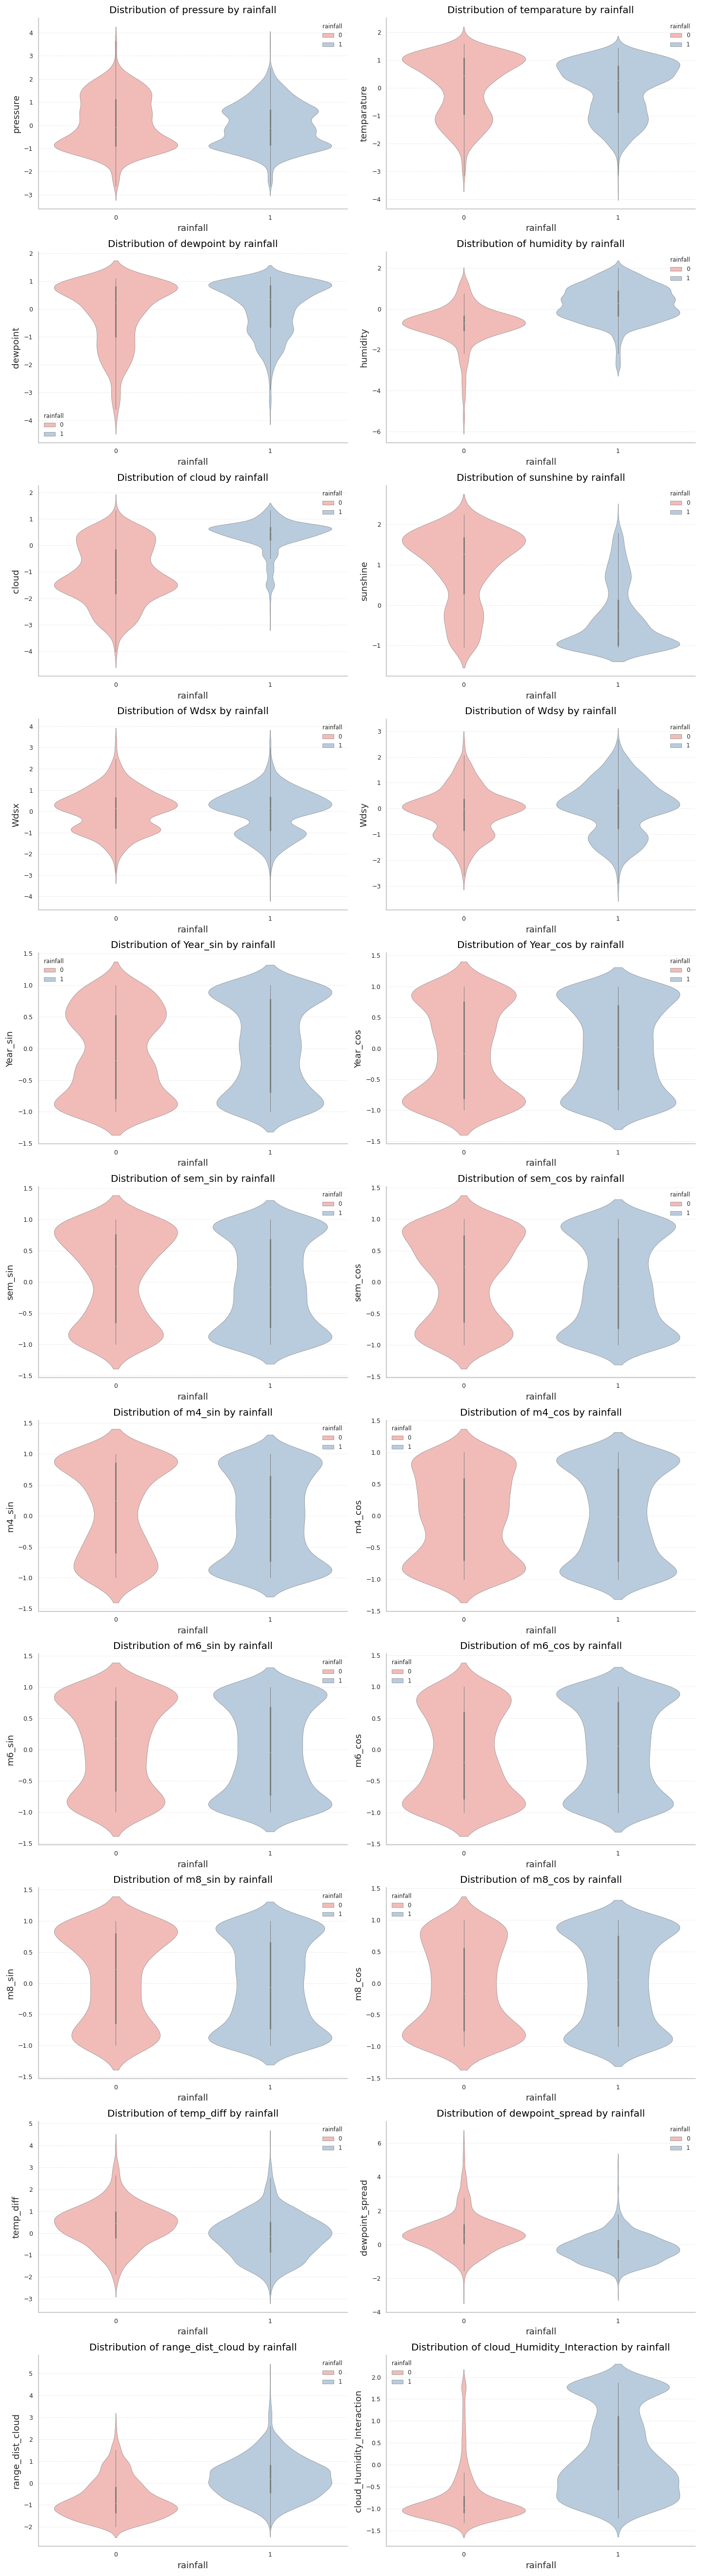

In [74]:
plot_instance.plot_numerical_features(df=X_enc_y, target_variable="rainfall", features_cat=t.cat_features, features_num=t.num_features);

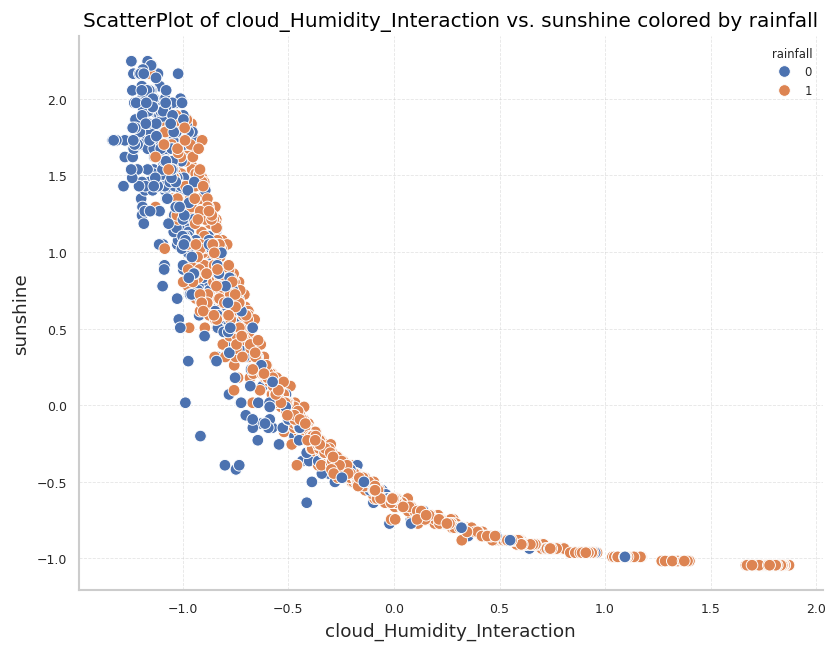

In [75]:
plot_instance.scatter_comp(feat_01="cloud_Humidity_Interaction", feat_02="sunshine", hue_def="rainfall")


Correlation Heatmap



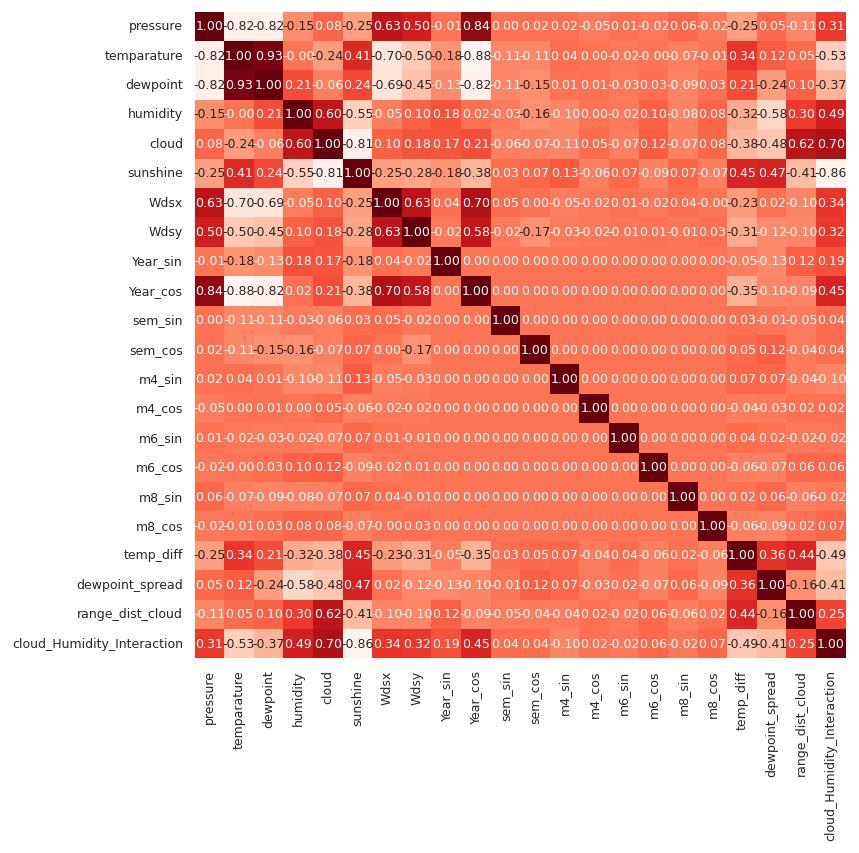

In [76]:
plot_instance.heatmap_corr()

In [77]:
print(X_enc_y.shape,test_enc.shape)
X_enc_y_old = X_enc_y.iloc[2191:,:]
X_enc_y_new = X_enc_y.iloc[:2190,:]
print(X_enc_y_new.shape,X_enc_y_old.shape,test_enc.shape)

(2556, 23) (730, 22)
(2190, 23) (365, 23) (730, 22)


In [125]:
X_enc_y_old.to_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/X_enc_y_old.csv", index=False)
X_enc_y_new.to_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/X_enc_y_new.csv", index=False)
test_enc.to_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/test_enc.csv", index=False)

### **1.0 Baseline Stacked Model**

In [79]:
X_enc.shape, y.shape, test_enc.shape, cat_features

((2556, 22), (2556,), (730, 22), [])

In [87]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights = dict(enumerate(class_weights))

sample_pos_weight = class_weights[1]/class_weights[0]
sample_pos_weight

0.3459715639810426

In [81]:
Config.submission

rainfall
id            
2190         0
2191         0
2192         0
2193         0
2194         0
...        ...
2915         0
2916         0
2917         0
2918         0
2919         0

[730 rows x 1 columns]

In [93]:
# Meta-learner

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Define a common random seed for reproducibility
RANDOM_SEED = 42
N_ESTIMATORS = 1500  # Number of estimators for the ensemble models

X = X_enc.copy()
y = y.copy()

X_test = test_enc.copy()

df_subm_stack = Config.submission.copy()

cv = StratifiedKFold(5, shuffle=True, random_state=RANDOM_SEED)
auc_ = []

# Initialize the Stack
df_subm_stack['rainfall'] = 0.0

i=0

oof_results_stack = pd.DataFrame(columns=list(range(5)), index=X.index)

for idx_train, idx_valid in cv.split(X, y):

    print(f"Fold {i}")

    # Split the data into training and validation sets for the current fold
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

    # Define base estimators with random seed and number of estimators
    estimators = [
        ('lgbm', LGBMClassifier(objective="binary", random_state=RANDOM_SEED, n_estimators=N_ESTIMATORS,subsample=0.9, colsample_bytree=0.95, learning_rate=0.015, verbose= -1, scale_pos_weight= sample_pos_weight)),
        ('xgb', XGBClassifier(objective='binary:logistic',eval_metric="auc" ,random_state=RANDOM_SEED, n_estimators=N_ESTIMATORS, colsample_bytree = 0.95, subsample= 0.90, learning_rate=0.015,enable_categorical=True, tree_method='hist')),
        ('catboost', CatBoostClassifier(objective="Logloss",eval_metric="AUC",random_seed=RANDOM_SEED, iterations=N_ESTIMATORS, bootstrap_type='Bernoulli', subsample=0.9, learning_rate=0.015,task_type='CPU'))
    ]

    meta_model = LogisticRegression(C=1.0, class_weight="balanced")

    # Create StackingRegressor
    stacking_model = StackingClassifier(estimators=estimators, final_estimator=meta_model)
    if i >= 10:
        #print(stacking_model.get_params())
        # Fit the StackingRegressor
        stacking_model.fit(X_train, y_train)
        obj = sio.dump(stacking_model, f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Models/S5E3/staked_base_{i}_02.skops")

    else:
        unknown_types = sio.get_untrusted_types(file=f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Models/S5E3/staked_base_{i}_02.skops")
        stacking_model = sio.load(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Models/S5E3/staked_base_{i}_02.skops", trusted=unknown_types)


    stack_preds = stacking_model.predict_proba(X_valid)[:, 1]

    oof_results_stack.iloc[idx_valid,i] = stack_preds.flatten()
    # Prepare the test data and make predictions
    error = roc_auc_score(y_valid, stack_preds)

    auc_.append(error)
    print(f"AUC fold {i}: {error}")

    # Aggregate the predictions across the 5 folds (averaging for ensemble)
    df_subm_stack['rainfall'] += stacking_model.predict_proba(X_test)[:, 1] / 5
    i += 1

Fold 0
AUC fold 0: 0.885506379585327
Fold 1
AUC fold 1: 0.8878063479308959
Fold 2
AUC fold 2: 0.903555644837284
Fold 3
AUC fold 3: 0.8600441944556046
Fold 4
AUC fold 4: 0.8884024946030222


In [89]:
rmse,auc_

([0.8854764752791068,
  0.8700482121333868,
  0.9013358778625954,
  0.8495178786661309,
  0.866144958823059],
 [0.885506379585327,
  0.8878063479308959,
  0.903555644837284,
  0.8600441944556046,
  0.8884024946030222])

In [95]:
df_subm_stack.to_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/stacking_baseline_00.csv")
oof_results_stack.mean(axis=1).to_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/oof_results_stack_baseline_00.csv")

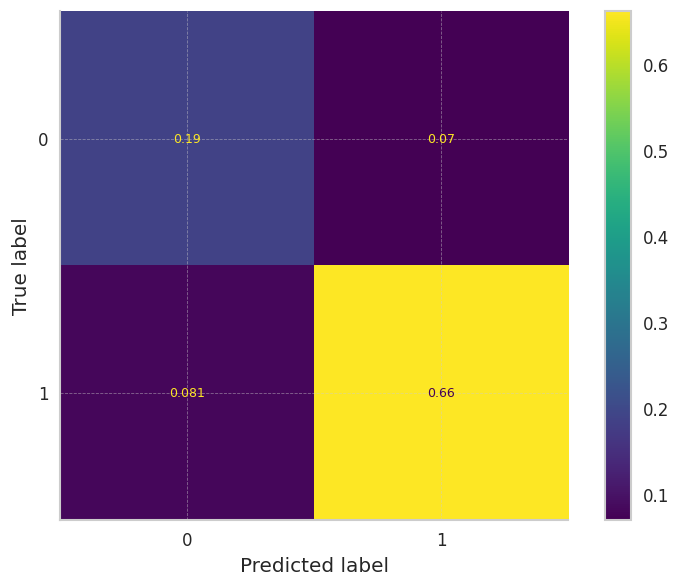

In [123]:
results_round = oof_results_stack.mean(axis=1)
results_round = [np.round(z) for z in results_round]


ConfusionMatrixDisplay.from_predictions(y,results_round,normalize="all");

In [124]:
roc_auc_score(y,oof_results_stack.mean(axis=1))

0.8830851453500721

## **4.0 MODELS**

--------------------

### **4.1 TREE BASED MODELS**

In [126]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights = dict(enumerate(class_weights))

sample_pos_weight = class_weights[1]/class_weights[0]
sample_pos_weight

0.3459715639810426

#### 4.1.1 CatBoostClassifier:

    class CatBoostClassifier(iterations=None,
                            learning_rate=None,
                            depth=None,
                            l2_leaf_reg=None,
                            model_size_reg=None,
                            rsm=None,
                            loss_function=None,
                            border_count=None,
                            feature_border_type=None,
                            per_float_feature_quantization=None,
                            input_borders=None,
                            output_borders=None,
                            fold_permutation_block=None,
                            od_pval=None,
                            od_wait=None,
                            od_type=None,
                            nan_mode=None,
                            counter_calc_method=None,
                            leaf_estimation_iterations=None,
                            leaf_estimation_method=None,
                            thread_count=None,
                            random_seed=None,
                            use_best_model=None,
                            verbose=None,
                            logging_level=None,
                            metric_period=None,
                            ctr_leaf_count_limit=None,
                            store_all_simple_ctr=None,
                            max_ctr_complexity=None,
                            has_time=None,
                            allow_const_label=None,
                            classes_count=None,
                            class_weights=None,
                            auto_class_weights=None,
                            one_hot_max_size=None,
                            random_strength=None,
                            name=None,
                            ignored_features=None,
                            train_dir=None,
                            custom_loss=None,
                            custom_metric=None,
                            eval_metric=None,
                            bagging_temperature=None,
                            save_snapshot=None,
                            snapshot_file=None,
                            snapshot_interval=None,
                            fold_len_multiplier=None,
                            used_ram_limit=None,
                            gpu_ram_part=None,
                            allow_writing_files=None,
                            final_ctr_computation_mode=None,
                            approx_on_full_history=None,
                            boosting_type=None,
                            simple_ctr=None,
                            combinations_ctr=None,
                            per_feature_ctr=None,
                            task_type=None,
                            device_config=None,
                            devices=None,
                            bootstrap_type=None,
                            subsample=None,
                            sampling_unit=None,
                            dev_score_calc_obj_block_size=None,
                            max_depth=None,
                            n_estimators=None,
                            num_boost_round=None,
                            num_trees=None,
                            colsample_bylevel=None,
                            random_state=None,
                            reg_lambda=None,
                            objective=None,
                            eta=None,
                            max_bin=None,
                            scale_pos_weight=None,
                            gpu_cat_features_storage=None,
                            data_partition=None
                            metadata=None,
                            early_stopping_rounds=None,
                            cat_features=None,
                            grow_policy=None,
                            min_data_in_leaf=None,
                            min_child_samples=None,
                            max_leaves=None,
                            num_leaves=None,
                            score_function=None,
                            leaf_estimation_backtracking=None,
                            ctr_history_unit=None,
                            monotone_constraints=None,
                            feature_weights=None,
                            penalties_coefficient=None,
                            first_feature_use_penalties=None,
                            model_shrink_rate=None,
                            model_shrink_mode=None,
                            langevin=None,
                            diffusion_temperature=None,
                            posterior_sampling=None,
                            boost_from_average=None,
                            text_features=None,
                            tokenizers=None,
                            dictionaries=None,
                            feature_calcers=None,
                            text_processing=None,
                            fixed_binary_splits=None)


In [127]:
cat_prob = {"objective":"Logloss","eval_metric":"AUC"}

##### 4.1.2 Optuna Optimization:

In [128]:
def objective_catboost(trial, X, y, n_splits, n_repeats, model=CatBoostClassifier, use_gpu=True, rs=42, fit_scaling=False, cv_strategy="StratKFold", metrics=cat_prob):

    model_class = model

    categorical_features = t.cat_features.copy()

    num_cols = [col for col in X.columns if col not in categorical_features]

    params = {
        'iterations': 2501,
        'learning_rate': 0.025, #trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'depth': trial.suggest_int('depth', 7, 11),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-4, 0.1, log=True),
        "bootstrap_type": "Bernoulli",
        'subsample': trial.suggest_float('subsample', 0.75, 0.95,step=0.025),
        'random_strength': trial.suggest_float('random_strength', 0.0, 1.0),
        #'border_count': trial.suggest_int('border_count', 32, 255),
        'cat_features': categorical_features,
        'task_type': 'GPU' if use_gpu else 'CPU',
        'random_seed':rs,
        'verbose': 100,
        'objective': metrics["objective"],
        'eval_metric': metrics["eval_metric"],
        "od_type":'EBS', #Early stopping hyperparmeter
        "od_wait":101,
        "scale_pos_weight":sample_pos_weight,
        "sampling_frequency":"PerTreeLevel",
        "use_best_model":True,
    }

    if cv_strategy == 'RepKFold':
      kf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)
    elif cv_strategy == 'KFold':
      kf = KFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "StratKFold":
      kf = StratifiedKFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "RepStratKFold":
      kf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)

    auc_scores = []

    for idx_train, idx_valid in kf.split(X, y):

        # Split the data into training and validation sets for the current fold
        X_train, y_train = X.iloc[idx_train], y.iloc[idx_train].to_numpy().reshape(-1,1)
        X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid].to_numpy().reshape(-1,1)

        if fit_scaling:
          scaler = StandardScaler()
          X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
          X_valid[num_cols] = scaler.transform(X_valid[num_cols])

        # Create the Pool objects for CatBoost
        train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_features)
        valid_pool = Pool(data=X_valid, label=y_valid, cat_features=categorical_features)

        # Create the pipeline
        model = model_class(**params)
        # Fit the model:
        model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=101,
                  #callbacks=[optuna.integration.CatBoostPruningCallback(trial, "RMSE")]
                  )

        # Make predictions on the validation set
        y_pred = model.predict_proba(X_valid)[:, 1]

#        y_pred = np.expm1(y_pred)
#        y_valid = np.expm1(y_valid)

        # Calculate the RMSE for the current fold

        auc_score = roc_auc_score(y_valid, y_pred)
        auc_scores.append(auc_score)

    # Calculate the mean RMSLE score across all folds
    key_metric = np.mean(auc_scores)

    return key_metric

In [129]:
# Step 2: Tuning Hyperparameters with Optuna
def tune_hyperparameters(X, y, model_class, n_trials, n_splits_ ,n_repeats_, use_gpu=True):  #use_gpu
    study = optuna.create_study(direction=t.direction_, sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner(n_warmup_steps=50))
    study.optimize(lambda trial: objective_catboost(trial, X, y, n_splits=n_splits_, n_repeats=n_repeats_, model=model_class, use_gpu=use_gpu, cv_strategy="StratKFold"), n_trials=n_trials)
    return study  # Return the study object

# Step 3: Saving Best Results and Models
def save_results(study, model_class, model_name):
    best_params_file = f"{model_name}_best_params.joblib"
    joblib.dump(study.best_params, best_params_file)
    print(f"Best parameters for {model_name} saved to {best_params_file}")

    verbose_file = f"{model_name}_optuna_verbose.log"
    with open(verbose_file, "w") as f:
        f.write(str(study.trials))
    print(f"Optuna verbose for {model_name} saved to {verbose_file}")

In [130]:
# usage with XGBRegressor
cat_study = tune_hyperparameters(X_enc, y, model_class=CatBoostClassifier, n_trials=31, n_splits_ = 3 ,n_repeats_=5, use_gpu=False)
save_results(cat_study, CatBoostClassifier, "CatBoost_ext")
cat_params = cat_study.best_params

[I 2025-03-05 01:48:08,714] A new study created in memory with name: no-name-482e4654-bf3e-4c77-a7db-a994707c3456


0:	test: 0.8556919	best: 0.8556919 (0)	total: 33.1ms	remaining: 1m 22s
100:	test: 0.8870855	best: 0.8872225 (99)	total: 1.66s	remaining: 39.3s
200:	test: 0.8842505	best: 0.8875472 (102)	total: 2.93s	remaining: 33.5s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8875471589
bestIteration = 102

Shrink model to first 103 iterations.
0:	test: 0.8330700	best: 0.8330700 (0)	total: 15.6ms	remaining: 39s
100:	test: 0.8710136	best: 0.8755149 (63)	total: 1.14s	remaining: 27.1s
200:	test: 0.8763733	best: 0.8769720 (171)	total: 2.57s	remaining: 29.4s
300:	test: 0.8771668	best: 0.8782055 (223)	total: 3.81s	remaining: 27.8s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8782055444
bestIteration = 223

Shrink model to first 224 iterations.
0:	test: 0.8203308	best: 0.8203308 (0)	total: 9.83ms	remaining: 24.6s
100:	test: 0.8778737	best: 0.8792010 (87)	total: 1.13s	remaining: 26.8s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.879201021

[I 2025-03-05 01:48:18,591] Trial 0 finished with value: 0.8816512415811254 and parameters: {'depth': 7, 'l2_leaf_reg': 0.009665505142708728, 'subsample': 0.95, 'random_strength': 0.3164428143564263}. Best is trial 0 with value: 0.8816512415811254.


0:	test: 0.8090884	best: 0.8090884 (0)	total: 106ms	remaining: 4m 24s
100:	test: 0.8948257	best: 0.8991827 (78)	total: 7.95s	remaining: 3m 8s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8991826989
bestIteration = 78

Shrink model to first 79 iterations.
0:	test: 0.8024158	best: 0.8024158 (0)	total: 45ms	remaining: 1m 52s
100:	test: 0.8657477	best: 0.8674212 (69)	total: 5.74s	remaining: 2m 16s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8674212094
bestIteration = 69

Shrink model to first 70 iterations.
0:	test: 0.8324425	best: 0.8324425 (0)	total: 45.6ms	remaining: 1m 54s
100:	test: 0.8699965	best: 0.8774625 (63)	total: 4.62s	remaining: 1m 49s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8774625434
bestIteration = 63

Shrink model to first 64 iterations.


[I 2025-03-05 01:48:47,512] Trial 1 finished with value: 0.8813554839004426 and parameters: {'depth': 10, 'l2_leaf_reg': 0.0034098068868676497, 'subsample': 0.825, 'random_strength': 0.5316398538050704}. Best is trial 0 with value: 0.8816512415811254.


0:	test: 0.8338094	best: 0.8338094 (0)	total: 48.6ms	remaining: 2m 1s
100:	test: 0.8920629	best: 0.8952946 (40)	total: 4.08s	remaining: 1m 37s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8952945674
bestIteration = 40

Shrink model to first 41 iterations.
0:	test: 0.8269313	best: 0.8269313 (0)	total: 23.2ms	remaining: 58.1s
100:	test: 0.8723048	best: 0.8724996 (96)	total: 3.97s	remaining: 1m 34s
200:	test: 0.8742958	best: 0.8753417 (191)	total: 6.48s	remaining: 1m 14s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8753417444
bestIteration = 191

Shrink model to first 192 iterations.
0:	test: 0.7938064	best: 0.7938064 (0)	total: 46ms	remaining: 1m 54s
100:	test: 0.8681281	best: 0.8690298 (67)	total: 3.89s	remaining: 1m 32s
200:	test: 0.8675438	best: 0.8693977 (163)	total: 6.27s	remaining: 1m 11s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8693977364
bestIteration = 163

Shrink model to first 164 iterations.


[I 2025-03-05 01:49:09,463] Trial 2 finished with value: 0.8800113494004295 and parameters: {'depth': 9, 'l2_leaf_reg': 0.03291489689989629, 'subsample': 0.875, 'random_strength': 0.3751350955201439}. Best is trial 0 with value: 0.8816512415811254.


0:	test: 0.8790207	best: 0.8790207 (0)	total: 13.2ms	remaining: 33s
100:	test: 0.8898555	best: 0.8904470 (83)	total: 1.32s	remaining: 31.3s
200:	test: 0.8870206	best: 0.8909015 (113)	total: 2.61s	remaining: 29.9s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8909014838
bestIteration = 113

Shrink model to first 114 iterations.
0:	test: 0.8042084	best: 0.8042084 (0)	total: 13.1ms	remaining: 32.7s
100:	test: 0.8690948	best: 0.8694122 (99)	total: 1.32s	remaining: 31.5s
200:	test: 0.8712300	best: 0.8717854 (149)	total: 2.77s	remaining: 31.7s
300:	test: 0.8713815	best: 0.8732642 (261)	total: 5.21s	remaining: 38.1s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.873264227
bestIteration = 261

Shrink model to first 262 iterations.
0:	test: 0.8149495	best: 0.8149495 (0)	total: 13ms	remaining: 32.6s
100:	test: 0.8714103	best: 0.8729540 (72)	total: 1.31s	remaining: 31.1s
200:	test: 0.8722615	best: 0.8732859 (137)	total: 2.6s	remaining: 29.8s
Stopped by

[I 2025-03-05 01:49:22,090] Trial 3 finished with value: 0.8791505262322636 and parameters: {'depth': 8, 'l2_leaf_reg': 0.03002432629914722, 'subsample': 0.775, 'random_strength': 0.2314392649544672}. Best is trial 0 with value: 0.8816512415811254.


0:	test: 0.8107800	best: 0.8107800 (0)	total: 92.2ms	remaining: 3m 50s
100:	test: 0.8940033	best: 0.8976462 (34)	total: 10.9s	remaining: 4m 18s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8976462017
bestIteration = 34

Shrink model to first 35 iterations.
0:	test: 0.7932978	best: 0.7932978 (0)	total: 98ms	remaining: 4m 5s
100:	test: 0.8647450	best: 0.8647450 (100)	total: 11s	remaining: 4m 21s
200:	test: 0.8643771	best: 0.8648027 (104)	total: 20s	remaining: 3m 48s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8648026719
bestIteration = 104

Shrink model to first 105 iterations.
0:	test: 0.8187583	best: 0.8187583 (0)	total: 160ms	remaining: 6m 41s
100:	test: 0.8794463	best: 0.8801244 (79)	total: 10.7s	remaining: 4m 15s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8801243625
bestIteration = 79

Shrink model to first 80 iterations.


[I 2025-03-05 01:50:16,778] Trial 4 finished with value: 0.8808577453646597 and parameters: {'depth': 11, 'l2_leaf_reg': 0.09058047776973213, 'subsample': 0.875, 'random_strength': 0.737694961528539}. Best is trial 0 with value: 0.8816512415811254.


0:	test: 0.8216437	best: 0.8216437 (0)	total: 90.8ms	remaining: 3m 46s
100:	test: 0.8865156	best: 0.8869051 (72)	total: 10.8s	remaining: 4m 17s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8869051483
bestIteration = 72

Shrink model to first 73 iterations.
0:	test: 0.8244534	best: 0.8244534 (0)	total: 90.1ms	remaining: 3m 45s
100:	test: 0.8694266	best: 0.8697368 (91)	total: 10.8s	remaining: 4m 16s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8697367757
bestIteration = 91

Shrink model to first 92 iterations.
0:	test: 0.7950688	best: 0.7950688 (0)	total: 181ms	remaining: 7m 32s
100:	test: 0.8724779	best: 0.8739351 (55)	total: 9.37s	remaining: 3m 42s
200:	test: 0.8731849	best: 0.8743823 (188)	total: 20.1s	remaining: 3m 49s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8743823353
bestIteration = 188

Shrink model to first 189 iterations.


[I 2025-03-05 01:51:24,795] Trial 5 finished with value: 0.8770080864478059 and parameters: {'depth': 11, 'l2_leaf_reg': 0.05809530249365071, 'subsample': 0.775, 'random_strength': 0.022151632962787215}. Best is trial 0 with value: 0.8816512415811254.


0:	test: 0.8476091	best: 0.8476091 (0)	total: 105ms	remaining: 4m 23s
100:	test: 0.8854624	best: 0.8962468 (20)	total: 9.47s	remaining: 3m 44s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8962467629
bestIteration = 20

Shrink model to first 21 iterations.
0:	test: 0.7764685	best: 0.7764685 (0)	total: 127ms	remaining: 5m 18s
100:	test: 0.8623068	best: 0.8639298 (47)	total: 8.92s	remaining: 3m 32s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8639298261
bestIteration = 47

Shrink model to first 48 iterations.
0:	test: 0.8305236	best: 0.8305236 (0)	total: 170ms	remaining: 7m 5s
100:	test: 0.8732065	best: 0.8762795 (52)	total: 9.25s	remaining: 3m 39s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8762795126
bestIteration = 52

Shrink model to first 53 iterations.


[I 2025-03-05 01:52:10,206] Trial 6 finished with value: 0.8788187005417415 and parameters: {'depth': 11, 'l2_leaf_reg': 0.0008574995261202788, 'subsample': 0.875, 'random_strength': 0.18868025393108445}. Best is trial 0 with value: 0.8816512415811254.


0:	test: 0.8391619	best: 0.8391619 (0)	total: 7.8ms	remaining: 19.5s
100:	test: 0.8930295	best: 0.8936210 (89)	total: 780ms	remaining: 18.5s
200:	test: 0.8916661	best: 0.8954533 (153)	total: 1.53s	remaining: 17.5s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8954532667
bestIteration = 153

Shrink model to first 154 iterations.
0:	test: 0.8384622	best: 0.8384622 (0)	total: 7.68ms	remaining: 19.2s
100:	test: 0.8696502	best: 0.8705014 (80)	total: 783ms	remaining: 18.6s
200:	test: 0.8720163	best: 0.8732714 (184)	total: 1.52s	remaining: 17.4s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8732714406
bestIteration = 184

Shrink model to first 185 iterations.
0:	test: 0.8245147	best: 0.8245147 (0)	total: 7.76ms	remaining: 19.4s
100:	test: 0.8734734	best: 0.8737259 (97)	total: 773ms	remaining: 18.4s
200:	test: 0.8696574	best: 0.8747574 (120)	total: 1.53s	remaining: 17.5s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.874757442

[I 2025-03-05 01:52:16,245] Trial 7 finished with value: 0.8811607166473102 and parameters: {'depth': 7, 'l2_leaf_reg': 0.007318971488841598, 'subsample': 0.775, 'random_strength': 0.839232473139998}. Best is trial 0 with value: 0.8816512415811254.


0:	test: 0.8840161	best: 0.8840161 (0)	total: 7.76ms	remaining: 19.4s
100:	test: 0.8926616	best: 0.8943857 (90)	total: 783ms	remaining: 18.6s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8943856536
bestIteration = 90

Shrink model to first 91 iterations.
0:	test: 0.8165509	best: 0.8165509 (0)	total: 7.65ms	remaining: 19.1s
100:	test: 0.8666494	best: 0.8673419 (51)	total: 1.37s	remaining: 32.6s
200:	test: 0.8696141	best: 0.8696141 (200)	total: 2.97s	remaining: 34s
300:	test: 0.8713238	best: 0.8713238 (300)	total: 4.19s	remaining: 30.6s
400:	test: 0.8721245	best: 0.8723481 (398)	total: 4.95s	remaining: 25.9s
500:	test: 0.8702850	best: 0.8724635 (403)	total: 5.72s	remaining: 22.8s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8724635172
bestIteration = 403

Shrink model to first 404 iterations.
0:	test: 0.8232018	best: 0.8232018 (0)	total: 7.87ms	remaining: 19.7s
100:	test: 0.8687774	best: 0.8719658 (59)	total: 782ms	remaining: 18.6s
Stopped 

[I 2025-03-05 01:52:24,944] Trial 8 finished with value: 0.8796049831562396 and parameters: {'depth': 7, 'l2_leaf_reg': 0.0027321650415562306, 'subsample': 0.9, 'random_strength': 0.13998927087427693}. Best is trial 0 with value: 0.8816512415811254.


0:	test: 0.8407309	best: 0.8407309 (0)	total: 24.3ms	remaining: 1m
100:	test: 0.8823101	best: 0.8875183 (45)	total: 2.35s	remaining: 55.9s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8875183045
bestIteration = 45

Shrink model to first 46 iterations.
0:	test: 0.8119089	best: 0.8119089 (0)	total: 23.1ms	remaining: 57.8s
100:	test: 0.8646295	best: 0.8676953 (87)	total: 2.35s	remaining: 55.9s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8676953263
bestIteration = 87

Shrink model to first 88 iterations.
0:	test: 0.8259863	best: 0.8259863 (0)	total: 40.6ms	remaining: 1m 41s
100:	test: 0.8685826	best: 0.8715690 (58)	total: 3.16s	remaining: 1m 15s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8715690306
bestIteration = 58

Shrink model to first 59 iterations.


[I 2025-03-05 01:52:38,742] Trial 9 finished with value: 0.8755942204621032 and parameters: {'depth': 9, 'l2_leaf_reg': 0.00022427283053476203, 'subsample': 0.825, 'random_strength': 0.46178680582389353}. Best is trial 0 with value: 0.8816512415811254.


0:	test: 0.8320132	best: 0.8320132 (0)	total: 16.6ms	remaining: 41.5s
100:	test: 0.8947103	best: 0.8972639 (76)	total: 1.36s	remaining: 32.3s
200:	test: 0.8960159	best: 0.8977544 (129)	total: 2.69s	remaining: 30.7s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8977544057
bestIteration = 129

Shrink model to first 130 iterations.
0:	test: 0.8238330	best: 0.8238330 (0)	total: 14.9ms	remaining: 37.2s
100:	test: 0.8708405	best: 0.8708405 (100)	total: 1.32s	remaining: 31.4s
200:	test: 0.8700830	best: 0.8708910 (101)	total: 2.62s	remaining: 30s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.870890952
bestIteration = 101

Shrink model to first 102 iterations.
0:	test: 0.7994114	best: 0.7994114 (0)	total: 13.3ms	remaining: 33.3s
100:	test: 0.8693905	best: 0.8719441 (72)	total: 1.66s	remaining: 39.4s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8719441379
bestIteration = 72

Shrink model to first 73 iterations.


[I 2025-03-05 01:52:48,279] Trial 10 finished with value: 0.8801964985176047 and parameters: {'depth': 8, 'l2_leaf_reg': 0.011881766227252831, 'subsample': 0.95, 'random_strength': 0.9914816440022788}. Best is trial 0 with value: 0.8816512415811254.


0:	test: 0.8088395	best: 0.8088395 (0)	total: 85.6ms	remaining: 3m 34s
100:	test: 0.8914064	best: 0.8922216 (65)	total: 5.17s	remaining: 2m 2s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.892221573
bestIteration = 65

Shrink model to first 66 iterations.
0:	test: 0.8046448	best: 0.8046448 (0)	total: 47.9ms	remaining: 1m 59s
100:	test: 0.8699604	best: 0.8711795 (91)	total: 6.33s	remaining: 2m 30s
200:	test: 0.8723842	best: 0.8728098 (191)	total: 11s	remaining: 2m 5s
300:	test: 0.8728170	best: 0.8736249 (226)	total: 15.7s	remaining: 1m 54s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8736249071
bestIteration = 226

Shrink model to first 227 iterations.
0:	test: 0.8161614	best: 0.8161614 (0)	total: 84.6ms	remaining: 3m 31s
100:	test: 0.8743463	best: 0.8746565 (94)	total: 5.92s	remaining: 2m 20s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8746564522
bestIteration = 94

Shrink model to first 95 iterations.


[I 2025-03-05 01:53:24,572] Trial 11 finished with value: 0.8801676441097334 and parameters: {'depth': 10, 'l2_leaf_reg': 0.0018386496282629023, 'subsample': 0.95, 'random_strength': 0.6137240378942241}. Best is trial 0 with value: 0.8816512415811254.


0:	test: 0.8514647	best: 0.8514647 (0)	total: 45.8ms	remaining: 1m 54s
100:	test: 0.8911467	best: 0.8941115 (29)	total: 6.38s	remaining: 2m 31s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8941115367
bestIteration = 29

Shrink model to first 30 iterations.
0:	test: 0.8221018	best: 0.8221018 (0)	total: 44.2ms	remaining: 1m 50s
100:	test: 0.8612392	best: 0.8614844 (99)	total: 4.59s	remaining: 1m 49s
200:	test: 0.8651273	best: 0.8654952 (197)	total: 9.88s	remaining: 1m 53s
300:	test: 0.8653076	best: 0.8661733 (242)	total: 15.4s	remaining: 1m 52s
400:	test: 0.8662310	best: 0.8662310 (400)	total: 20s	remaining: 1m 44s
500:	test: 0.8662310	best: 0.8666205 (408)	total: 26.3s	remaining: 1m 44s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8666204996
bestIteration = 408

Shrink model to first 409 iterations.
0:	test: 0.8215427	best: 0.8215427 (0)	total: 44.8ms	remaining: 1m 51s
100:	test: 0.8769720	best: 0.8797420 (82)	total: 4.7s	remaining: 1m 51s

[I 2025-03-05 01:54:07,963] Trial 12 finished with value: 0.8801580259737761 and parameters: {'depth': 10, 'l2_leaf_reg': 0.01063642168670777, 'subsample': 0.825, 'random_strength': 0.4029288983557099}. Best is trial 0 with value: 0.8816512415811254.


0:	test: 0.8088107	best: 0.8088107 (0)	total: 47.8ms	remaining: 1m 59s
100:	test: 0.8918537	best: 0.8932675 (34)	total: 6.43s	remaining: 2m 32s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8932675453
bestIteration = 34

Shrink model to first 35 iterations.
0:	test: 0.8009948	best: 0.8009948 (0)	total: 47.1ms	remaining: 1m 57s
100:	test: 0.8689361	best: 0.8703139 (79)	total: 4.69s	remaining: 1m 51s
200:	test: 0.8696502	best: 0.8720307 (160)	total: 11s	remaining: 2m 5s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8720307011
bestIteration = 160

Shrink model to first 161 iterations.
0:	test: 0.7907514	best: 0.7907514 (0)	total: 49ms	remaining: 2m 2s
100:	test: 0.8636629	best: 0.8678035 (53)	total: 4.68s	remaining: 1m 51s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8678035303
bestIteration = 53

Shrink model to first 54 iterations.


[I 2025-03-05 01:54:38,289] Trial 13 finished with value: 0.8777005922367215 and parameters: {'depth': 10, 'l2_leaf_reg': 0.0005170638354078938, 'subsample': 0.825, 'random_strength': 0.5923379714829513}. Best is trial 0 with value: 0.8816512415811254.


0:	test: 0.8230035	best: 0.8230035 (0)	total: 38.8ms	remaining: 1m 37s
100:	test: 0.8901657	best: 0.8947463 (36)	total: 2.82s	remaining: 1m 6s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8947463337
bestIteration = 36

Shrink model to first 37 iterations.
0:	test: 0.8232740	best: 0.8232740 (0)	total: 24.1ms	remaining: 1m
100:	test: 0.8706745	best: 0.8708188 (99)	total: 1.91s	remaining: 45.4s
200:	test: 0.8748945	best: 0.8750893 (198)	total: 3.23s	remaining: 37s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8750892683
bestIteration = 198

Shrink model to first 199 iterations.
0:	test: 0.7930670	best: 0.7930670 (0)	total: 13.4ms	remaining: 33.6s
100:	test: 0.8713454	best: 0.8716917 (87)	total: 1.35s	remaining: 32.1s
200:	test: 0.8673635	best: 0.8718431 (102)	total: 2.65s	remaining: 30.4s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8718431474
bestIteration = 102

Shrink model to first 103 iterations.


[I 2025-03-05 01:54:49,574] Trial 14 finished with value: 0.8805595831499876 and parameters: {'depth': 8, 'l2_leaf_reg': 0.004667068484888985, 'subsample': 0.925, 'random_strength': 0.3070304816785303}. Best is trial 0 with value: 0.8816512415811254.


0:	test: 0.8269096	best: 0.8269096 (0)	total: 23.7ms	remaining: 59.4s
100:	test: 0.8917455	best: 0.8921206 (85)	total: 3.42s	remaining: 1m 21s
200:	test: 0.8900503	best: 0.8924668 (107)	total: 6.55s	remaining: 1m 14s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8924668355
bestIteration = 107

Shrink model to first 108 iterations.
0:	test: 0.7967423	best: 0.7967423 (0)	total: 23.5ms	remaining: 58.7s
100:	test: 0.8650119	best: 0.8650119 (100)	total: 2.37s	remaining: 56.4s
200:	test: 0.8628189	best: 0.8662887 (114)	total: 4.75s	remaining: 54.3s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8662886739
bestIteration = 114

Shrink model to first 115 iterations.
0:	test: 0.7935828	best: 0.7935828 (0)	total: 26.2ms	remaining: 1m 5s
100:	test: 0.8638072	best: 0.8638072 (100)	total: 2.42s	remaining: 57.4s
200:	test: 0.8688928	best: 0.8692246 (196)	total: 6.36s	remaining: 1m 12s
300:	test: 0.8686259	best: 0.8702129 (217)	total: 8.97s	remaining: 1m 5s

[I 2025-03-05 01:55:11,152] Trial 15 finished with value: 0.8763227942608584 and parameters: {'depth': 9, 'l2_leaf_reg': 0.0013327466984619557, 'subsample': 0.75, 'random_strength': 0.5808266780878706}. Best is trial 0 with value: 0.8816512415811254.


0:	test: 0.8510896	best: 0.8510896 (0)	total: 7.78ms	remaining: 19.4s
100:	test: 0.8946237	best: 0.8954100 (94)	total: 776ms	remaining: 18.4s
200:	test: 0.8972999	best: 0.8978338 (186)	total: 1.53s	remaining: 17.5s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8978337553
bestIteration = 186

Shrink model to first 187 iterations.
0:	test: 0.8273533	best: 0.8273533 (0)	total: 7.68ms	remaining: 19.2s
100:	test: 0.8704437	best: 0.8731849 (54)	total: 787ms	remaining: 18.7s
200:	test: 0.8715762	best: 0.8740649 (172)	total: 1.55s	remaining: 17.7s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8740649368
bestIteration = 172

Shrink model to first 173 iterations.
0:	test: 0.8535206	best: 0.8535206 (0)	total: 7.72ms	remaining: 19.3s
100:	test: 0.8759477	best: 0.8798214 (52)	total: 781ms	remaining: 18.6s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8798213912
bestIteration = 52

Shrink model to first 53 iterations.


[I 2025-03-05 01:55:16,869] Trial 16 finished with value: 0.8839066944630796 and parameters: {'depth': 7, 'l2_leaf_reg': 0.00010066495380483784, 'subsample': 0.85, 'random_strength': 0.6861887430866555}. Best is trial 16 with value: 0.8839066944630796.


0:	test: 0.8775816	best: 0.8775816 (0)	total: 7.98ms	remaining: 19.9s
100:	test: 0.8904831	best: 0.8919691 (86)	total: 754ms	remaining: 17.9s
200:	test: 0.8924380	best: 0.8939096 (174)	total: 1.56s	remaining: 17.8s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8939095559
bestIteration = 174

Shrink model to first 175 iterations.
0:	test: 0.8272054	best: 0.8272054 (0)	total: 9.61ms	remaining: 24s
100:	test: 0.8714969	best: 0.8724779 (81)	total: 1.49s	remaining: 35.4s
200:	test: 0.8740000	best: 0.8742236 (199)	total: 2.82s	remaining: 32.3s
300:	test: 0.8757746	best: 0.8773183 (248)	total: 3.59s	remaining: 26.2s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8773182713
bestIteration = 248

Shrink model to first 249 iterations.
0:	test: 0.8418670	best: 0.8418670 (0)	total: 7.77ms	remaining: 19.4s
100:	test: 0.8817546	best: 0.8853759 (85)	total: 782ms	remaining: 18.6s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8853758647

[I 2025-03-05 01:55:25,204] Trial 17 finished with value: 0.8855345639738291 and parameters: {'depth': 7, 'l2_leaf_reg': 0.00019305410603361395, 'subsample': 0.9, 'random_strength': 0.7381880700306409}. Best is trial 17 with value: 0.8855345639738291.


0:	test: 0.8775707	best: 0.8775707 (0)	total: 7.9ms	remaining: 19.8s
100:	test: 0.8907428	best: 0.8922937 (33)	total: 786ms	remaining: 18.7s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.892293709
bestIteration = 33

Shrink model to first 34 iterations.
0:	test: 0.8277753	best: 0.8277753 (0)	total: 7.83ms	remaining: 19.6s
100:	test: 0.8722615	best: 0.8731416 (89)	total: 765ms	remaining: 18.2s
200:	test: 0.8709126	best: 0.8741948 (109)	total: 1.52s	remaining: 17.5s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8741947817
bestIteration = 109

Shrink model to first 110 iterations.
0:	test: 0.8418418	best: 0.8418418 (0)	total: 7.81ms	remaining: 19.5s
100:	test: 0.8738990	best: 0.8765392 (85)	total: 772ms	remaining: 18.3s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8765392023
bestIteration = 85

Shrink model to first 86 iterations.


[I 2025-03-05 01:55:29,523] Trial 18 finished with value: 0.8810092310059848 and parameters: {'depth': 7, 'l2_leaf_reg': 0.00012684071385464556, 'subsample': 0.9, 'random_strength': 0.7514692518927646}. Best is trial 17 with value: 0.8855345639738291.


0:	test: 0.8485035	best: 0.8485035 (0)	total: 13.4ms	remaining: 33.6s
100:	test: 0.8958356	best: 0.8993486 (67)	total: 1.32s	remaining: 31.3s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8993486117
bestIteration = 67

Shrink model to first 68 iterations.
0:	test: 0.8376976	best: 0.8376976 (0)	total: 12.9ms	remaining: 32.4s
100:	test: 0.8700686	best: 0.8720740 (92)	total: 2.05s	remaining: 48.7s
200:	test: 0.8724996	best: 0.8739062 (188)	total: 4.35s	remaining: 49.8s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8739062376
bestIteration = 188

Shrink model to first 189 iterations.
0:	test: 0.8162948	best: 0.8162948 (0)	total: 13.3ms	remaining: 33.3s
100:	test: 0.8682941	best: 0.8741659 (70)	total: 1.35s	remaining: 32.2s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8741659273
bestIteration = 70

Shrink model to first 71 iterations.


[I 2025-03-05 01:55:39,742] Trial 19 finished with value: 0.8824735922054625 and parameters: {'depth': 8, 'l2_leaf_reg': 0.00010927703224845378, 'subsample': 0.85, 'random_strength': 0.9456268957870919}. Best is trial 17 with value: 0.8855345639738291.


0:	test: 0.8774409	best: 0.8774409 (0)	total: 7.73ms	remaining: 19.3s
100:	test: 0.8932315	best: 0.8932315 (100)	total: 762ms	remaining: 18.1s
200:	test: 0.8904326	best: 0.8933974 (101)	total: 1.52s	remaining: 17.4s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8933973901
bestIteration = 101

Shrink model to first 102 iterations.
0:	test: 0.8272811	best: 0.8272811 (0)	total: 9.26ms	remaining: 23.2s
100:	test: 0.8664546	best: 0.8674212 (74)	total: 769ms	remaining: 18.3s
200:	test: 0.8728314	best: 0.8735239 (197)	total: 1.53s	remaining: 17.5s
300:	test: 0.8723553	best: 0.8747574 (272)	total: 2.27s	remaining: 16.6s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8747574426
bestIteration = 272

Shrink model to first 273 iterations.
0:	test: 0.8418598	best: 0.8418598 (0)	total: 7.83ms	remaining: 19.6s
100:	test: 0.8768782	best: 0.8779314 (90)	total: 782ms	remaining: 18.6s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8779314

[I 2025-03-05 01:55:45,810] Trial 20 finished with value: 0.882028753417444 and parameters: {'depth': 7, 'l2_leaf_reg': 0.0003155818361257564, 'subsample': 0.9, 'random_strength': 0.7169595381772109}. Best is trial 17 with value: 0.8855345639738291.


0:	test: 0.8569110	best: 0.8569110 (0)	total: 13.4ms	remaining: 33.5s
100:	test: 0.8969176	best: 0.8991611 (79)	total: 2.33s	remaining: 55.5s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8991610581
bestIteration = 79

Shrink model to first 80 iterations.
0:	test: 0.8376543	best: 0.8376543 (0)	total: 13.1ms	remaining: 32.8s
100:	test: 0.8661228	best: 0.8705303 (30)	total: 1.32s	remaining: 31.3s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8705302719
bestIteration = 30

Shrink model to first 31 iterations.
0:	test: 0.8161541	best: 0.8161541 (0)	total: 16.2ms	remaining: 40.5s
100:	test: 0.8741731	best: 0.8753201 (79)	total: 1.31s	remaining: 31.3s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8753201036
bestIteration = 79

Shrink model to first 80 iterations.


[I 2025-03-05 01:55:54,222] Trial 21 finished with value: 0.8816704778530396 and parameters: {'depth': 8, 'l2_leaf_reg': 0.0001028414359799213, 'subsample': 0.85, 'random_strength': 0.9551012219732055}. Best is trial 17 with value: 0.8855345639738291.


0:	test: 0.8485540	best: 0.8485540 (0)	total: 13.3ms	remaining: 33.2s
100:	test: 0.8922649	best: 0.8969248 (27)	total: 1.32s	remaining: 31.4s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8969248415
bestIteration = 27

Shrink model to first 28 iterations.
0:	test: 0.8377733	best: 0.8377733 (0)	total: 13.1ms	remaining: 32.8s
100:	test: 0.8667071	best: 0.8686187 (84)	total: 1.29s	remaining: 30.7s
200:	test: 0.8651201	best: 0.8693905 (130)	total: 2.58s	remaining: 29.5s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8693905228
bestIteration = 130

Shrink model to first 131 iterations.
0:	test: 0.8176221	best: 0.8176221 (0)	total: 13.2ms	remaining: 33.1s
100:	test: 0.8731127	best: 0.8786384 (62)	total: 1.8s	remaining: 42.8s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8786383605
bestIteration = 62

Shrink model to first 63 iterations.


[I 2025-03-05 01:56:02,510] Trial 22 finished with value: 0.8816512415811254 and parameters: {'depth': 8, 'l2_leaf_reg': 0.0002259249406105016, 'subsample': 0.85, 'random_strength': 0.8994160781375645}. Best is trial 17 with value: 0.8855345639738291.


0:	test: 0.8392088	best: 0.8392088 (0)	total: 10.9ms	remaining: 27.3s
100:	test: 0.8960809	best: 0.8992404 (85)	total: 1.26s	remaining: 30s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8992404077
bestIteration = 85

Shrink model to first 86 iterations.
0:	test: 0.8381737	best: 0.8381737 (0)	total: 7.54ms	remaining: 18.9s
100:	test: 0.8720091	best: 0.8724996 (82)	total: 761ms	remaining: 18.1s
200:	test: 0.8725212	best: 0.8734374 (138)	total: 1.51s	remaining: 17.3s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8734373535
bestIteration = 138

Shrink model to first 139 iterations.
0:	test: 0.8241937	best: 0.8241937 (0)	total: 7.74ms	remaining: 19.4s
100:	test: 0.8682291	best: 0.8709126 (87)	total: 769ms	remaining: 18.3s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8709125928
bestIteration = 87

Shrink model to first 88 iterations.


[I 2025-03-05 01:56:07,920] Trial 23 finished with value: 0.8811967846571496 and parameters: {'depth': 7, 'l2_leaf_reg': 0.0004859770553687276, 'subsample': 0.8, 'random_strength': 0.8225683515067013}. Best is trial 17 with value: 0.8855345639738291.


0:	test: 0.8525143	best: 0.8525143 (0)	total: 17.1ms	remaining: 42.8s
100:	test: 0.8844958	best: 0.8858736 (56)	total: 1.36s	remaining: 32.2s
200:	test: 0.8875544	best: 0.8885066 (140)	total: 2.64s	remaining: 30.3s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.888506568
bestIteration = 140

Shrink model to first 141 iterations.
0:	test: 0.8235445	best: 0.8235445 (0)	total: 13.1ms	remaining: 32.7s
100:	test: 0.8639515	best: 0.8681859 (61)	total: 1.31s	remaining: 31.2s
200:	test: 0.8711939	best: 0.8719441 (171)	total: 2.8s	remaining: 32.1s
300:	test: 0.8711651	best: 0.8722471 (233)	total: 5.22s	remaining: 38.1s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8722471091
bestIteration = 233

Shrink model to first 234 iterations.
0:	test: 0.8478507	best: 0.8478507 (0)	total: 25.2ms	remaining: 1m 2s
100:	test: 0.8707900	best: 0.8727665 (80)	total: 1.35s	remaining: 32s
200:	test: 0.8679045	best: 0.8740433 (119)	total: 2.63s	remaining: 30.1s
Stopped 

[I 2025-03-05 01:56:20,342] Trial 24 finished with value: 0.8782656577242047 and parameters: {'depth': 8, 'l2_leaf_reg': 0.00016603596524248488, 'subsample': 0.85, 'random_strength': 0.6658802675555551}. Best is trial 17 with value: 0.8855345639738291.


0:	test: 0.8391259	best: 0.8391259 (0)	total: 7.89ms	remaining: 19.7s
100:	test: 0.8935849	best: 0.8955326 (83)	total: 763ms	remaining: 18.1s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8955326163
bestIteration = 83

Shrink model to first 84 iterations.
0:	test: 0.8382422	best: 0.8382422 (0)	total: 10.5ms	remaining: 26.3s
100:	test: 0.8689866	best: 0.8726150 (78)	total: 784ms	remaining: 18.6s
200:	test: 0.8721389	best: 0.8732642 (193)	total: 1.56s	remaining: 17.9s
300:	test: 0.8743535	best: 0.8743535 (300)	total: 2.32s	remaining: 17s
400:	test: 0.8731777	best: 0.8743535 (300)	total: 3.08s	remaining: 16.1s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8743534809
bestIteration = 300

Shrink model to first 301 iterations.
0:	test: 0.8248501	best: 0.8248501 (0)	total: 7.77ms	remaining: 19.4s
100:	test: 0.8726294	best: 0.8741154 (81)	total: 775ms	remaining: 18.4s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8741154321
b

[I 2025-03-05 01:56:26,500] Trial 25 finished with value: 0.8813338430945391 and parameters: {'depth': 7, 'l2_leaf_reg': 0.00038794173783746787, 'subsample': 0.925, 'random_strength': 0.8227228979001675}. Best is trial 17 with value: 0.8855345639738291.


0:	test: 0.8364460	best: 0.8364460 (0)	total: 13.3ms	remaining: 33.3s
100:	test: 0.8874029	best: 0.8926039 (37)	total: 1.63s	remaining: 38.7s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8926038939
bestIteration = 37

Shrink model to first 38 iterations.
0:	test: 0.8235697	best: 0.8235697 (0)	total: 23.3ms	remaining: 58.2s
100:	test: 0.8645141	best: 0.8649469 (99)	total: 2.27s	remaining: 54s
200:	test: 0.8677170	best: 0.8677170 (200)	total: 3.57s	remaining: 40.8s
300:	test: 0.8694627	best: 0.8697728 (283)	total: 4.87s	remaining: 35.6s
400:	test: 0.8708260	best: 0.8708837 (388)	total: 6.17s	remaining: 32.3s
500:	test: 0.8717422	best: 0.8717422 (500)	total: 7.45s	remaining: 29.7s
600:	test: 0.8723481	best: 0.8724996 (569)	total: 8.75s	remaining: 27.6s
700:	test: 0.8724058	best: 0.8730118 (625)	total: 10.1s	remaining: 25.9s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.873011751
bestIteration = 625

Shrink model to first 626 iterations.
0:	te

[I 2025-03-05 01:56:42,404] Trial 26 finished with value: 0.8782488259862798 and parameters: {'depth': 8, 'l2_leaf_reg': 0.0007212729676281932, 'subsample': 0.875, 'random_strength': 0.9010499057478585}. Best is trial 17 with value: 0.8855345639738291.


0:	test: 0.8774445	best: 0.8774445 (0)	total: 16.8ms	remaining: 41.9s
100:	test: 0.8900503	best: 0.8912045 (90)	total: 1.59s	remaining: 37.9s
200:	test: 0.8920484	best: 0.8946309 (150)	total: 2.83s	remaining: 32.3s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8946309161
bestIteration = 150

Shrink model to first 151 iterations.
0:	test: 0.8278221	best: 0.8278221 (0)	total: 7.78ms	remaining: 19.4s
100:	test: 0.8707611	best: 0.8707611 (100)	total: 779ms	remaining: 18.5s
200:	test: 0.8729829	best: 0.8730911 (172)	total: 1.55s	remaining: 17.7s
300:	test: 0.8714103	best: 0.8736970 (204)	total: 2.3s	remaining: 16.8s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8736970431
bestIteration = 204

Shrink model to first 205 iterations.
0:	test: 0.8247564	best: 0.8247564 (0)	total: 8.06ms	remaining: 20.1s
100:	test: 0.8783354	best: 0.8790784 (82)	total: 768ms	remaining: 18.2s
200:	test: 0.8707827	best: 0.8795689 (105)	total: 1.54s	remaining: 17.6s
Stop

[I 2025-03-05 01:56:49,830] Trial 27 finished with value: 0.8826322914487558 and parameters: {'depth': 7, 'l2_leaf_reg': 0.00016150234107099659, 'subsample': 0.925, 'random_strength': 0.6718830789361074}. Best is trial 17 with value: 0.8855345639738291.


0:	test: 0.8774445	best: 0.8774445 (0)	total: 7.86ms	remaining: 19.7s
100:	test: 0.8873740	best: 0.8890404 (91)	total: 784ms	remaining: 18.6s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8890403745
bestIteration = 91

Shrink model to first 92 iterations.
0:	test: 0.8275913	best: 0.8275913 (0)	total: 7.89ms	remaining: 19.7s
100:	test: 0.8682075	best: 0.8689793 (77)	total: 770ms	remaining: 18.3s
200:	test: 0.8741371	best: 0.8741371 (200)	total: 1.54s	remaining: 17.6s
300:	test: 0.8761929	best: 0.8761929 (300)	total: 2.38s	remaining: 17.4s
400:	test: 0.8759333	best: 0.8774481 (347)	total: 3.14s	remaining: 16.5s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8774481162
bestIteration = 347

Shrink model to first 348 iterations.
0:	test: 0.8248646	best: 0.8248646 (0)	total: 13.2ms	remaining: 33s
100:	test: 0.8760992	best: 0.8805716 (55)	total: 1.66s	remaining: 39.4s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8805716058
b

[I 2025-03-05 01:56:57,651] Trial 28 finished with value: 0.8823533655059981 and parameters: {'depth': 7, 'l2_leaf_reg': 0.0002412333636038476, 'subsample': 0.925, 'random_strength': 0.6757575419323638}. Best is trial 17 with value: 0.8855345639738291.


0:	test: 0.8631724	best: 0.8631724 (0)	total: 11.8ms	remaining: 29.5s
100:	test: 0.8825986	best: 0.8858159 (86)	total: 1.28s	remaining: 30.4s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8858158945
bestIteration = 86

Shrink model to first 87 iterations.
0:	test: 0.8307004	best: 0.8307004 (0)	total: 7.78ms	remaining: 19.5s
100:	test: 0.8710857	best: 0.8714248 (99)	total: 763ms	remaining: 18.1s
200:	test: 0.8709847	best: 0.8721533 (195)	total: 1.52s	remaining: 17.5s
300:	test: 0.8734301	best: 0.8747647 (289)	total: 2.28s	remaining: 16.7s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8747646562
bestIteration = 289

Shrink model to first 290 iterations.
0:	test: 0.8186464	best: 0.8186464 (0)	total: 7.81ms	remaining: 19.5s
100:	test: 0.8702634	best: 0.8719946 (59)	total: 768ms	remaining: 18.3s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8719946331
bestIteration = 59

Shrink model to first 60 iterations.


[I 2025-03-05 01:57:04,094] Trial 29 finished with value: 0.8775250612555033 and parameters: {'depth': 7, 'l2_leaf_reg': 0.0001649723849685625, 'subsample': 0.925, 'random_strength': 0.49740794502623953}. Best is trial 17 with value: 0.8855345639738291.


0:	test: 0.8775491	best: 0.8775491 (0)	total: 7.97ms	remaining: 19.9s
100:	test: 0.8975813	best: 0.8988869 (84)	total: 767ms	remaining: 18.2s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8988869412
bestIteration = 84

Shrink model to first 85 iterations.
0:	test: 0.8275011	best: 0.8275011 (0)	total: 7.79ms	remaining: 19.5s
100:	test: 0.8747935	best: 0.8765681 (31)	total: 767ms	remaining: 18.2s
200:	test: 0.8750388	best: 0.8782344 (142)	total: 1.52s	remaining: 17.4s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8782343988
bestIteration = 142

Shrink model to first 143 iterations.
0:	test: 0.8418815	best: 0.8418815 (0)	total: 7.86ms	remaining: 19.7s
100:	test: 0.8730622	best: 0.8753778 (87)	total: 783ms	remaining: 18.6s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8753778124
bestIteration = 87

Shrink model to first 88 iterations.


[I 2025-03-05 01:57:09,304] Trial 30 finished with value: 0.8841663841339229 and parameters: {'depth': 7, 'l2_leaf_reg': 0.0007695268367214758, 'subsample': 0.9, 'random_strength': 0.7914225219876433}. Best is trial 17 with value: 0.8855345639738291.


Best parameters for CatBoost_ext saved to CatBoost_ext_best_params.joblib
Optuna verbose for CatBoost_ext saved to CatBoost_ext_optuna_verbose.log


#### **4.2.1 LGBMClassifier**

In [ ]:
import lightgbm as lgb
lgbm_prob = {"objective":"binary","eval_metric":"auc"}

##### 4.2.2 Optuna Optimization:

In [ ]:
X_enc.info()
t.cat_features

In [ ]:
def objective_lgbm(trial, X, y, n_splits, n_repeats, model=LGBMClassifier, use_gpu=True, rs=42, fit_scaling=False, cv_strategy="KFold", metrics=lgbm_prob):

    model_class = model

    categorical_features = t.cat_features.copy()

    num_cols = [col for col in X.columns if col not in categorical_features]

    params = {
        'num_leaves': trial.suggest_int('num_leaves', 20, 200),
        'learning_rate': 0.02, #trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 50),
        'subsample': trial.suggest_float('subsample', 0.5, 0.95),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.95),
        "reg_alpha" :         trial.suggest_float("reg_alpha", 1e-3, 1.0, log=True),
        "reg_lambda" :        trial.suggest_float("reg_lambda", 1e-3, 1.0, log=True),
        "boosting_type":      'gbdt',
        'n_estimators': 2501,
        'objective': metrics["objective"],
        'metric': metrics["eval_metric"],
        'device': 'gpu' if use_gpu else 'cpu',
        'verbose': -1,
        'scale_pos_weight': sample_pos_weight,
        'cat_features': categorical_features,
#       'categorical_feature': [2,4,5,9],
        'random_state': rs,
    }

    if cv_strategy == 'RepKFold':
        kf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)
    elif cv_strategy == 'KFold':
        kf = KFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "StratKFold":
        kf = StratifiedKFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "RepStratKFold":
        kf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)

    auc_scores = []

    for idx_train, idx_valid in kf.split(X, y):

        # Split the data into training and validation sets for the current fold
        X_train, y_train = X.iloc[idx_train], y.iloc[idx_train].to_numpy().reshape(-1, 1)
        X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid].to_numpy().reshape(-1, 1)

        if fit_scaling:
            scaler = StandardScaler()
            X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
            X_valid[num_cols] = scaler.transform(X_valid[num_cols])

        # Create the datasets for LightGBM
        # d_train = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
        # d_valid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=categorical_features)

        # Create the model
        model = model_class(**params)

        # Create the early stopping callback
        early_stop = early_stopping(stopping_rounds=101)

        # Fit the model
        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], callbacks=[early_stop])

        # Make predictions on the validation set
        y_pred = model.predict_proba(X_valid)[:, 1]

        # Calculate the AUC for the current fold
        auc_score = roc_auc_score(y_valid, y_pred)
        auc_scores.append(auc_score)

    # Calculate the mean auc score across all folds
    key_metric = np.mean(auc_scores)

    return key_metric

In [ ]:
# Step 2: Tuning Hyperparameters with Optuna
def tune_hyperparameters(X, y, model_class, n_trials, n_splits_ ,n_repeats_, use_gpu=True):  #use_gpu
    study = optuna.create_study(direction=t.direction_, sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner(n_warmup_steps=50))
    study.optimize(lambda trial: objective_lgbm(trial, X, y, n_splits=n_splits_, n_repeats=n_repeats_, model=model_class, use_gpu=use_gpu, cv_strategy="StratKFold"), n_trials=n_trials)
    return study  # Return the study object

# Step 3: Saving Best Results and Models
def save_results(study, model_class, model_name):
    best_params_file = f"{model_name}_best_params.joblib"
    joblib.dump(study.best_params, best_params_file)
    print(f"Best parameters for {model_name} saved to {best_params_file}")

    verbose_file = f"{model_name}_optuna_verbose.log"
    with open(verbose_file, "w") as f:
        f.write(str(study.trials))
    print(f"Optuna verbose for {model_name} saved to {verbose_file}")# usage with XGBRegressor

In [ ]:
cat_study = tune_hyperparameters(X_enc, y, model_class=LGBMClassifier, n_trials=31, n_splits_ = 3 ,n_repeats_=3, use_gpu=False)
save_results(cat_study, LGBMClassifier, "LGBMBoost_ext")
cat_params = cat_study.best_params

#### **4.3.1 XGBClassifier**

In [ ]:
import xgboost as xgb
xgb_prob = {'objective': 'binary:logistic','eval_metric': "auc"}

##### 4.2.2 Optuna Optimization:

In [ ]:
def objective_xgb(trial, X, y, n_splits, n_repeats, model=XGBClassifier, use_gpu=True, rs=42, fit_scaling=False, cv_strategy="KFold", metrics=xgb_prob):

    model_class = model

    categorical_features = t.cat_features.copy()

    num_cols = [col for col in X.columns if col not in categorical_features]

    params = {
              'n_estimators': 1000,
              'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
              'max_depth': trial.suggest_int('max_depth', 3, 10),
              'max_bin': trial.suggest_int('max_bin', 255, 511),
              'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
              'subsample': trial.suggest_float('subsample', 0.7, 0.95),
              'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.95),
              'gamma': trial.suggest_float('gamma', 0, 1),
              'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
              'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
              'objective':  metrics["objective"],  # For binary classification
              'eval_metric': metrics["eval_metric"],
              "early_stopping_rounds":101,
              'tree_method': 'gpu_hist' if use_gpu else 'hist',  # Use GPU if available
              'random_state': rs,
              'enable_categorical': True,
              'scale_pos_weight': sample_pos_weight,
             }

    if cv_strategy == 'RepKFold':
        kf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)
    elif cv_strategy == 'KFold':
        kf = KFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "StratKFold":
        kf = StratifiedKFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "RepStratKFold":
        kf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)

    auc_scores = []

    for idx_train, idx_valid in kf.split(X, y):

        # Split the data into training and validation sets for the current fold
        X_train, y_train = X.iloc[idx_train], y.iloc[idx_train].to_numpy().reshape(-1, 1)
        X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid].to_numpy().reshape(-1, 1)

        if fit_scaling:
            scaler = StandardScaler()
            X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
            X_valid[num_cols] = scaler.transform(X_valid[num_cols])

        # Create DMatrix objects for XGBoost
        d_train = xgb.DMatrix(X_train, label=y_train)
        d_valid = xgb.DMatrix(X_valid, label=y_valid)

        # Create the model
        model = model_class(**params)

        # Create the early stopping callback
        # early_stop = early_stopping(stopping_rounds=101)

        # Fit the model
        model.fit(X_train, y_train,
                  eval_set=[(X_valid, y_valid)],
                  verbose=False)

        # Make predictions on the validation set
        y_pred = model.predict_proba(X_valid)[:, 1]

        # Calculate the AUC for the current fold
        auc_score = roc_auc_score(y_valid, y_pred)
        auc_scores.append(auc_score)

    # Calculate the mean auc score across all folds
    key_metric = np.mean(auc_scores)

    return key_metric

In [ ]:
# Step 2: Tuning Hyperparameters with Optuna
def tune_hyperparameters(X, y, model_class, n_trials, n_splits_ ,n_repeats_, use_gpu=True):  #use_gpu
    study = optuna.create_study(direction=t.direction_, sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner(n_warmup_steps=50))
    study.optimize(lambda trial: objective_xgb(trial, X, y, n_splits=n_splits_, n_repeats=n_repeats_, model=model_class, use_gpu=use_gpu, cv_strategy="StratKFold"), n_trials=n_trials)
    return study  # Return the study object

# Step 3: Saving Best Results and Models
def save_results(study, model_class, model_name):
    best_params_file = f"{model_name}_best_params.joblib"
    joblib.dump(study.best_params, best_params_file)
    print(f"Best parameters for {model_name} saved to {best_params_file}")

    verbose_file = f"{model_name}_optuna_verbose.log"
    with open(verbose_file, "w") as f:
        f.write(str(study.trials))
    print(f"Optuna verbose for {model_name} saved to {verbose_file}")# usage with XGBRegressor

In [ ]:
cat_study = tune_hyperparameters(X_enc, y, model_class=XGBClassifier, n_trials=31, n_splits_ = 3 ,n_repeats_=3, use_gpu=False)
save_results(cat_study, XGBClassifier, "XGB_ext")
cat_params = cat_study.best_params

#### **4.4.1 TabNetClassifier**

In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
tab_prob = {'eval_metric': "auc"}

In [ ]:
X_enc.sample(3)

In [ ]:
grouped_features = []
feature_cols = X_enc.columns.to_list()

group_1 = ['person_home_ownership', 'loan_intent']
#group_2 = ['loan_grade']
#group_3 = ['cb_person_default_on_file']

# Iterate through each set of related columns (e.g., blood glucose, insulin, etc.)
for colset in [group_1]:
    group_idxs = [idx for idx, col in enumerate(feature_cols) if col in colset]
    grouped_features.append(group_idxs)

In [ ]:
grouped_features

##### 4.2.2 Optuna Optimization:

In [ ]:
cate_feat = t.cat_features.copy()

for colset in [cate_feat]:
    cat_index_cols = [idx for idx, col in enumerate(feature_cols) if col in colset]

cat_index_cols

In [ ]:
def objective_tabnet(trial, X, y, n_splits, n_repeats, model=TabNetClassifier, use_gpu=True, rs=42, fit_scaling=False, cv_strategy="KFold", metrics=tab_prob):

    model_class = model

    categorical_features = t.cat_features.copy()

    num_cols = [col for col in X.columns if col not in categorical_features]

    params = {'n_d': trial.suggest_categorical('n_d', [8,12,16]),
              'n_a': trial.suggest_categorical('n_d', [8,12,16]),
              'n_steps': trial.suggest_int('n_steps', 3, 5),
              'gamma': trial.suggest_float('gamma', 1.01, 2),
              'lambda_sparse':trial.suggest_float('lambda_sparse', 1e-5, 1e-1),
              "grouped_features":grouped_features,
              'cat_idxs': cat_index_cols,
              'cat_dims': [len(X_enc[col].unique()) for col in categorical_features],
              'n_independent': trial.suggest_int('n_independent', 2, 5),
              'n_shared': trial.suggest_int('n_shared', 2, 5),
              'mask_type': trial.suggest_categorical('mask_type', ['entmax', 'sparsemax']),
              'device_name': 'gpu' if use_gpu else 'cpu',
              'seed': rs,
              "optimizer_fn":torch.optim.Adam,
              "optimizer_params":dict(lr=0.01),
              "scheduler_params":{"patience":5, # how to use learning rate scheduler
                                "factor":0.5,
                                "min_lr":0.0001},
              "scheduler_fn":torch.optim.lr_scheduler.ReduceLROnPlateau,
              }

    if cv_strategy == 'RepKFold':
        kf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)
    elif cv_strategy == 'KFold':
        kf = KFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "StratKFold":
        kf = StratifiedKFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "RepStratKFold":
        kf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)

    auc_scores = []

    for idx_train, idx_valid in kf.split(X, y):

        # Split the data into training and validation sets for the current fold
        X_train, y_train = X.iloc[idx_train], y.iloc[idx_train].to_numpy()#.reshape(-1, 1)
        X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid].to_numpy()#.reshape(-1, 1)

        if fit_scaling:
            scaler = StandardScaler()
            X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
            X_valid[num_cols] = scaler.transform(X_valid[num_cols])

        # Create the model
        model = model_class(**params)

        # Fit the model
        model.fit(X_train.values, y_train,
                  eval_set=[(X_valid.values, y_valid)],
                  batch_size=256,
                  eval_metric=[tab_prob["eval_metric"]])

        # Make predictions on the validation set
        y_pred = model.predict_proba(X_valid)[:, 1]

        # Calculate the AUC for the current fold
        auc_score = roc_auc_score(y_valid, y_pred)
        auc_scores.append(auc_score)

    # Calculate the mean auc score across all folds
    key_metric = np.mean(auc_scores)

    return key_metric

In [ ]:
# Step 2: Tuning Hyperparameters with Optuna
def tune_hyperparameters(X, y, model_class, n_trials, n_splits_ ,n_repeats_, use_gpu=True):  #use_gpu
    study = optuna.create_study(direction=t.direction_, sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner(n_warmup_steps=50))
    study.optimize(lambda trial: objective_tabnet(trial, X, y, n_splits=n_splits_, n_repeats=n_repeats_, model=model_class, use_gpu=use_gpu, cv_strategy="StratKFold"), n_trials=n_trials)
    return study  # Return the study object

# Step 3: Saving Best Results and Models
def save_results(study, model_class, model_name):
    best_params_file = f"{model_name}_best_params.joblib"
    joblib.dump(study.best_params, best_params_file)
    print(f"Best parameters for {model_name} saved to {best_params_file}")

    verbose_file = f"{model_name}_optuna_verbose.log"
    with open(verbose_file, "w") as f:
        f.write(str(study.trials))
    print(f"Optuna verbose for {model_name} saved to {verbose_file}")# usage with XGBRegressor

In [ ]:
cat_study = tune_hyperparameters(X_enc, y, model_class=TabNetClassifier, n_trials=31, n_splits_ = 3 ,n_repeats_=3, use_gpu=False)
save_results(cat_study, TabNetClassifier, "tabnet_ext")
cat_params = cat_study.best_params

#### 4.5.1 Yggdrasil - RandomForest

In [ ]:
#!pip install ydf -U

In [ ]:
y.head()

##### 4.5.2 Optuna Optimization:

[HyperParameters Link](https://ydf.readthedocs.io/en/stable/hyperparameters/#lambda_loss)

In [ ]:
# import ydf

# def objective_ydf_gbt(trial, X, y, n_splits, n_repeats, model_ = ydf.GradientBoostedTreesLearner, rs=42, fit_scaling=False, cv_strategy="KFold", use_gpu=False):

#     model_class = model_  # Use ydf's GradientBoostedTreesLearner

#     categorical_features = t.cat_features.copy()  # Assuming 't' is defined somewhere with categorical features

#     num_cols = [col for col in X.columns if col not in categorical_features]
#     auc_scores = []

#     params = {
#         'loss':"BINOMIAL_LOG_LIKELIHOOD",
#         'num_trees': trial.suggest_int('num_trees', 100, 1000),  # Number of trees in the forest
#         'max_depth': trial.suggest_int('max_depth', 3, 10),  # Maximum depth of the trees
#         'min_examples': trial.suggest_int('min_examples', 1, 10),  # Minimum number of samples required to split an internal node
#         'l1_regularization': trial.suggest_float('l1_regularization', 1e-5, 10.0, log=True),
#         'l2_regularization': trial.suggest_float('l2_regularization', 1e-5, 10.0, log=True),
# #         'shrinkage': trial.suggest_float('shrinkage', 0.01, 0.3, log=True),  # Similar to learning rate, but applied after each tree is trained
#          'subsample': trial.suggest_float('subsample', 0.7, 1.0),  # Fraction of samples used for training each tree
# # #        'max_categorical_cardinality': trial.suggest_int('max_categorical_cardinality', 10, 100),  # Maximum number of unique values for categorical features
# #         'categorical_algorithm': trial.suggest_categorical('categorical_algorithm', ['CART', 'RANDOM']),  # Algorithm used for categorical splits
# #         'split_axis': trial.suggest_categorical('split_axis', ['AXIS_ALIGNED', 'SPARSE_OBLIQUE']),  # How to split numerical features
# #         'sparse_oblique_normalization': trial.suggest_categorical('sparse_oblique_normalization', ['NONE', 'STANDARD_DEVIATION', 'MIN_MAX']),  # Normalization for sparse oblique splits
# #         'sparse_oblique_num_projections_exponent': trial.suggest_float('sparse_oblique_num_projections_exponent', 0.5, 1.0),  # Exponent for the number of projections in sparse oblique splits
#         'random_seed': rs,  # Random seed for reproducibility
#         'early_stopping':"LOSS_INCREASE",  # Enable early stopping
#         'early_stopping_num_trees_look_ahead': 30,  # Number of trees to look ahead for early stopping
# #        'weights': {0:1,1:sample_pos_weight},
#         "label" : "loan_status",
#         }


#     if cv_strategy == 'RepKFold':
#         kf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)
#     elif cv_strategy == 'KFold':
#         kf = KFold(n_splits=n_splits, random_state=rs, shuffle=True)
#     elif cv_strategy == "StratKFold":
#         kf = StratifiedKFold(n_splits=n_splits, random_state=rs, shuffle=True)
#     elif cv_strategy == "RepStratKFold":
#         kf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)

#     for idx_train, idx_valid in kf.split(X, y):

#         # Split the data
#         X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
#         X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

#         if fit_scaling:
#             scaler = StandardScaler()
#             X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
#             X_valid[num_cols] = scaler.transform(X_valid[num_cols])

#         X_train["loan_status"] = y_train.values
#         X_valid["loan_status"] = y_valid.values

#         # Train the model with early stopping
#         model = model_class(task=ydf.Task.CLASSIFICATION, **params)
#         model.train(X_train, valid=(X_valid))  # Use ydf's fit method with early stopping

#         # Make predictions
#         y_pred = model.get_predictions(X_valid)["loan_status_probability_1"]

#         # Calculate AUC
#         auc_score = roc_auc_score(y_valid, y_pred)
#         auc_scores.append(auc_score)

#     # Calculate the mean AUC
#     key_metric = np.mean(auc_scores)

#     return key_metric

In [ ]:
# # Step 2: Tuning Hyperparameters with Optuna
# def tune_hyperparameters(X, y, model_class, n_trials, n_splits_ ,n_repeats_, use_gpu=True):  #use_gpu
#     study = optuna.create_study(direction=t.direction_, sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner(n_warmup_steps=50))
#     study.optimize(lambda trial: objective_ydf_gbt(trial, X, y, n_splits=n_splits_, n_repeats=n_repeats_, model_=model_class, use_gpu=use_gpu, cv_strategy="StratKFold"), n_trials=n_trials)
#     return study  # Return the study object

# # Step 3: Saving Best Results and Models
# def save_results(study, model_class, model_name):
#     best_params_file = f"{model_name}_best_params.joblib"
#     joblib.dump(study.best_params, best_params_file)
#     print(f"Best parameters for {model_name} saved to {best_params_file}")

#     verbose_file = f"{model_name}_ydf_verbose.log"
#     with open(verbose_file, "w") as f:
#         f.write(str(study.trials))
#     print(f"Optuna verbose for {model_name} saved to {verbose_file}")# usage with XGBRegressor

In [ ]:
# cat_study = tune_hyperparameters(X_enc, y, model_class=ydf.GradientBoostedTreesLearner, n_trials=31, n_splits_ = 3 ,n_repeats_=3, use_gpu=False)
# save_results(cat_study, TabNetClassifier, "ydf_ext")
# cat_params = cat_study.best_params

#### **4.6.1 NeuralNetwork**

In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
tab_prob = {'eval_metric': "auc"}

In [ ]:
X_enc.sample(3)

In [ ]:
grouped_features = []
feature_cols = X_enc.columns.to_list()

group_1 = ['person_home_ownership', 'loan_intent']
#group_2 = ['loan_grade']
#group_3 = ['cb_person_default_on_file']

# Iterate through each set of related columns (e.g., blood glucose, insulin, etc.)
for colset in [group_1]:
    group_idxs = [idx for idx, col in enumerate(feature_cols) if col in colset]
    grouped_features.append(group_idxs)

In [ ]:
grouped_features

##### 4.2.2 Optuna Optimization:

In [ ]:
cate_feat = t.cat_features.copy()

for colset in [cate_feat]:
    cat_index_cols = [idx for idx, col in enumerate(feature_cols) if col in colset]

cat_index_cols

In [ ]:
def objective_tabnet(trial, X, y, n_splits, n_repeats, model=TabNetClassifier, use_gpu=True, rs=42, fit_scaling=False, cv_strategy="KFold", metrics=tab_prob):

    model_class = model

    categorical_features = t.cat_features.copy()

    num_cols = [col for col in X.columns if col not in categorical_features]

    params = {'n_d': trial.suggest_categorical('n_d', [8,12,16]),
              'n_a': trial.suggest_categorical('n_d', [8,12,16]),
              'n_steps': trial.suggest_int('n_steps', 3, 5),
              'gamma': trial.suggest_float('gamma', 1.01, 2),
              'lambda_sparse':trial.suggest_float('lambda_sparse', 1e-5, 1e-1),
              "grouped_features":grouped_features,
              'cat_idxs': cat_index_cols,
              'cat_dims': [len(X_enc[col].unique()) for col in categorical_features],
              'n_independent': trial.suggest_int('n_independent', 2, 5),
              'n_shared': trial.suggest_int('n_shared', 2, 5),
              'mask_type': trial.suggest_categorical('mask_type', ['entmax', 'sparsemax']),
              'device_name': 'gpu' if use_gpu else 'cpu',
              'seed': rs,
              "optimizer_fn":torch.optim.Adam,
              "optimizer_params":dict(lr=0.01),
              "scheduler_params":{"patience":5, # how to use learning rate scheduler
                                "factor":0.5,
                                "min_lr":0.0001},
              "scheduler_fn":torch.optim.lr_scheduler.ReduceLROnPlateau,
              }

    if cv_strategy == 'RepKFold':
        kf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)
    elif cv_strategy == 'KFold':
        kf = KFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "StratKFold":
        kf = StratifiedKFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "RepStratKFold":
        kf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)

    auc_scores = []

    for idx_train, idx_valid in kf.split(X, y):

        # Split the data into training and validation sets for the current fold
        X_train, y_train = X.iloc[idx_train], y.iloc[idx_train].to_numpy()#.reshape(-1, 1)
        X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid].to_numpy()#.reshape(-1, 1)

        if fit_scaling:
            scaler = StandardScaler()
            X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
            X_valid[num_cols] = scaler.transform(X_valid[num_cols])

        # Create the model
        model = model_class(**params)

        # Fit the model
        model.fit(X_train.values, y_train,
                  eval_set=[(X_valid.values, y_valid)],
                  batch_size=256,
                  eval_metric=[tab_prob["eval_metric"]])

        # Make predictions on the validation set
        y_pred = model.predict_proba(X_valid)[:, 1]

        # Calculate the AUC for the current fold
        auc_score = roc_auc_score(y_valid, y_pred)
        auc_scores.append(auc_score)

    # Calculate the mean auc score across all folds
    key_metric = np.mean(auc_scores)

    return key_metric

In [ ]:
# Step 2: Tuning Hyperparameters with Optuna
def tune_hyperparameters(X, y, model_class, n_trials, n_splits_ ,n_repeats_, use_gpu=True):  #use_gpu
    study = optuna.create_study(direction=t.direction_, sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner(n_warmup_steps=50))
    study.optimize(lambda trial: objective_tabnet(trial, X, y, n_splits=n_splits_, n_repeats=n_repeats_, model=model_class, use_gpu=use_gpu, cv_strategy="StratKFold"), n_trials=n_trials)
    return study  # Return the study object

# Step 3: Saving Best Results and Models
def save_results(study, model_class, model_name):
    best_params_file = f"{model_name}_best_params.joblib"
    joblib.dump(study.best_params, best_params_file)
    print(f"Best parameters for {model_name} saved to {best_params_file}")

    verbose_file = f"{model_name}_optuna_verbose.log"
    with open(verbose_file, "w") as f:
        f.write(str(study.trials))
    print(f"Optuna verbose for {model_name} saved to {verbose_file}")# usage with XGBRegressor

In [ ]:
cat_study = tune_hyperparameters(X_enc, y, model_class=TabNetClassifier, n_trials=31, n_splits_ = 3 ,n_repeats_=3, use_gpu=False)
save_results(cat_study, TabNetClassifier, "tabnet_ext")
cat_params = cat_study.best_params